This notebook looks at implementing OT on each object type ("species") independently on a 3D ground space on the zero-padded data-challenge data.

IN PROGRESS

# Information about data

The data we are using was a part of the [ML4Jets 2021 data challenge](https://indico.cern.ch/event/980214/contributions/4413658/attachments/2278124/3870358/ml4jets_data_challenge.pdf). It is publically available in `.h5` format so it's great for testing out new methods!

**Publication:**

E. Govorkova, E. Puljak, T. Aarrestad, M. Pierini, K. A. Woźniak and J. Ngadiuba, LHC physics dataset for unsupervised New Physics detection at 40 MHz, Sci. Data 9, 118 (2022),
doi:[10.1038/s41597-022-01187-8](https://www.nature.com/articles/s41597-022-01187-8), arXiv:2107.02157

**Data:**

NOTE: The original data had several bugs in it. The links in the original materials (i.e. publication and slides) point to the incorrect Version 1 of the data. Version 2 should be used instead. [This website](https://mpp-hep.github.io/ADC2021/) contains the correct links/descriptions/usage information.

- `background_for_training.h5`: 4 million Standard Model (SM) background "training" data ([link to data](https://zenodo.org/record/5046428#.ZB9yKezMKHu))
-  `Ato4l_lepFilter_13TeV_filtered.h5`: # Neutral scalar boson events, $A \rightarrow 4l$, mass = $50$ GeV ([link to data](https://zenodo.org/record/7152590#.ZB9yROzMKHu))
- `leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5`: # Leptoquark events, ${\rm LQ} \rightarrow b \tau$ ([link to data](https://zenodo.org/record/7152599#.ZB9yZOzMKHu))
- `hToTauTau_13TeV_PU20_filtered.h5`: # Scalar boson events, $h^0 \rightarrow \tau \tau$ ([link to data](https://zenodo.org/record/7152614#.ZB9ybOzMKHt))
- `hChToTauNu_13TeV_PU20_filtered.h5`: # Charged scalar boson events, $h^\pm \rightarrow \tau \nu$ ([link to data](https://zenodo.org/record/7152617#.ZB9yf-zMKHt))
- `BlackBox_background_mix.h5`: # Mystery events ([link to data](https://zenodo.org/record/5072068#.ZB9yk-zMKHt))

In [ ]:
sigAliasList    = ['sig_A', 'sig_h0', 'sig_hch', 'sig_LQ']
sigFilenameList = ['Ato4l_lepFilter_13TeV_filtered.h5', 'hToTauTau_13TeV_PU20_filtered.h5', 'hChToTauNu_13TeV_PU20_filtered.h5', 'leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5']

# Google Drive preliminaries (since we're running on Google Colab)

In [ ]:
#-- "Mount" Google Drive to access data and save files/images --#
# NOTE: If running locally, comment out this cell and change the basePath accordingly
# Reference: https://stackoverflow.com/questions/49031798/when-i-use-google-colaboratory-how-to-save-image-weights-in-my-google-drive
from google.colab import drive
drive.mount('/content/gdrive')

# You will be asked to sign into a Google account and give GoogleColab access

Mounted at /content/gdrive


In [ ]:
# To check that mounting worked, uncomment and run the following. You should see the contents of the directory listed.
! ls '/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/Data/'

Ato4l_lepFilter_13TeV_filtered.h5
background_for_training.h5
BlackBox_background_mix.h5
hChToTauNu_13TeV_PU20_filtered.h5
hToTauTau_13TeV_PU20_filtered.h5
leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5
OldBuggedDatasets


In [ ]:
#-- Set base directory and data directory path --#
basePath   = '/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/'
dataPath   = 'Data/'

bkgPath    = basePath+dataPath+'background_for_training.h5'
sigPathList = []
for x in sigFilenameList:
  sigPathList.append(basePath+dataPath+x)

# Import libraries

We'll eventually be using the PyOT library to compute Wasserstein distances for now (see [here](https://pythonot.github.io/index.html)). But since this notebook is just visualizing the data we won't use it yet.

In [ ]:
import numpy as np
from numpy.random import RandomState
import numpy.ma as ma

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

import h5py
from numpy.random import Generator, PCG64
from sklearn import metrics
import itertools

# Functions

To keep things tidy, functions are externally defined in `centralFunctions.ipynb`. We run this notebook from here which defines the contained functions as if they were written here.


In [ ]:
%cd /content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge/
%run centralFunctions.ipynb

/content/gdrive/My Drive/Research/AnomalyDetectionWithOT/OnML4Jets2021DataChallenge
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.9/702.9 kB 7.5 MB/s eta 0:00:00


# Load data

For more details on the data structure, see [this exploratory notebook](https://colab.research.google.com/drive/138CL8n4gCtramqaaI-i0EUZ7n4f1SWVh?usp=sharing).

In [ ]:
dataDict = {}
dataDict['bkg'] = h5py.File(bkgPath, 'r')

for i in range(len(sigAliasList)):
  alias   = sigAliasList[i]
  sigPath = sigPathList[i]
  dataDict[alias] = h5py.File(sigPath, 'r')

# Optimal Transport Anomaly Score: Individual Species

We'll be using the 2-Wasserstein distance squared as our anomaly score. We assume the ground space is 3 dimensional $(p_T/{\rm GeV}, \eta, \phi)$, where $p_T$ is measured in ${\rm GeV}$.

       OTSCHEME:  Determines what scheme will be used to calculate the OT distance.
                  Note the exact meaning varies somewhat depending on the choice of COSTSCHEME.
                  It's a dictionary of 3 booleans cooresponding to whether the PT is normalized,
                  whether the OT calculation is balanced, and whether the zero padding should be
                  removed. Namely,
                  OTSCHEME['normPT']      ==True:  Means that the pT should be normalized;
                                         ==False:  Means that the pT should be unnormalized
                  OTSCHEME['balanced']    ==True:  Means that the OT calculation should be balanced;
                                         ==False:  Means that the OT calculation should be unbalanced
                  OTSCHEME['noZeroPad']   ==True:  Means that the zero padding should be removed;
                                         ==False:  Means that the zero padding should be kept
                  OTSCHEME['individualOT']==True:  Means that the OT calculation is done on each species separately;
                                         ==False:  Means that the OT calculation is done ignoring species type    
     COSTSCHEME:  Determines what scheme will be used to calculate the ground cost matrix. Options are:
                  - 1DpT: Ground space is pT only
                  - 2D:   Ground space is 2D (eta,phi); note mass is pT
                  - 3D:   Ground space is 3D (pT,eta,phi); note mass is uniform

In [ ]:
OTSCHEME = {}
OTSCHEME['normPT']       = False # pT should be unnormalized per event
OTSCHEME['balanced']     = True  # OT calculation is balanced
OTSCHEME['noZeroPad']    = False # zero padding is kept
OTSCHEME['individualOT'] = True  # Calculate individual species OT
COSTSCHEME            = '3D'  # pT, eta, phi ground space
kwargs                = {}    # No other arguments to pass to function

In [ ]:
# Define colors to use for 4 signal types
SIGNAL_COLOR_ARR = np.array([ RGBAtoRGBAtuple((231, 186, 81, 1), TYPE='list'),
                              RGBAtoRGBAtuple((140, 162, 82, 1), TYPE='list'),
                              RGBAtoRGBAtuple((165, 81, 148, 1), TYPE='list'),
                              RGBAtoRGBAtuple((214, 97, 107, 1), TYPE='list')
                              ])

#Species type = ${\rm MET}$

## Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [ ]:
nEvents   = 100

scoreDict = {}

# Generate 2 different samples of nEvents Background events
random_state            = Generator(PCG64(123))
scoreDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, 0, 0:3].reshape(-1,1,3), nEvents, random_state)

random_state            = Generator(PCG64(456))
scoreDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, 0, 0:3].reshape(-1,1,3), nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state          = Generator(PCG64(123))
  scoreDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, 0, 0:3].reshape(-1,1,3), nEvents, random_state)

## Calculate OT anomaly scores

In [ ]:
# nEvents = 100 takes about 16s of wall-clock time
# nEvents = 500 takes about 5 mins of wall-clock time

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTGeneral(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'])

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTGeneral(scoreDict['bkgEvents1'], scoreDict[alias])

In [ ]:
print('scoreDict keys:')
for key in scoreDict.keys():
  print("  ",key)

scoreDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ
   CBB
   wBB
   CBS_sig_A
   wBS_sig_A
   CBS_sig_h0
   wBS_sig_h0
   CBS_sig_hch
   wBS_sig_hch
   CBS_sig_LQ
   wBS_sig_LQ


In [ ]:
#-- Put in convenient list format --#
scoreBkg = scoreDict['wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'wBS_'+alias
  scoreSigList.append(scoreDict[name])

## Plot anomaly scores for all signal types

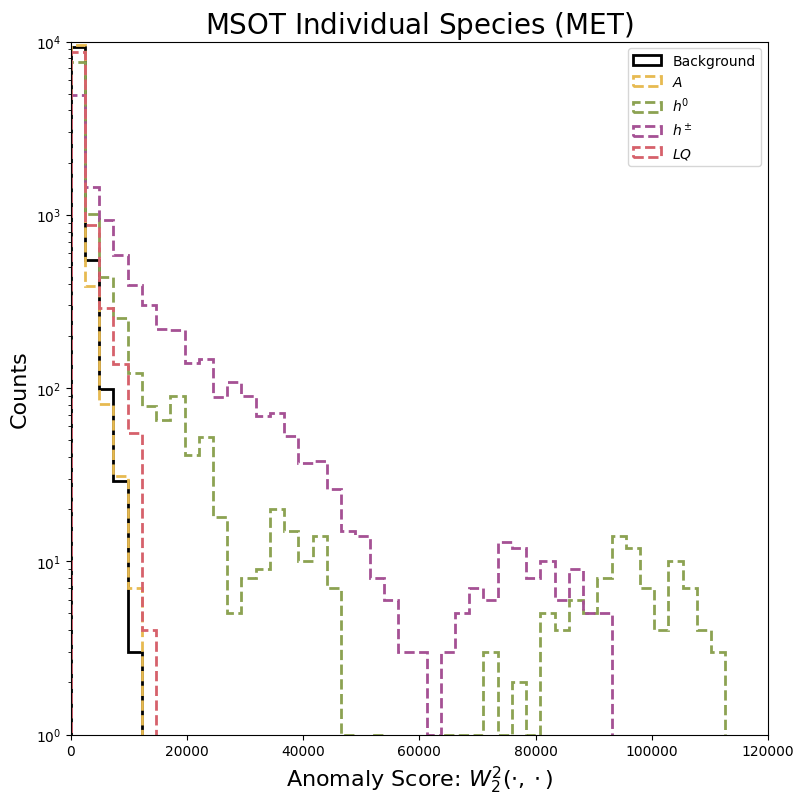

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 120000)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 1e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r'MSOT Individual Species (${\rm MET}$)'
plotArgDict['nBins']              = 50
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

## Get AUCs, ROC, and SI curves

In [ ]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(scoreBkg, scoreSigList)

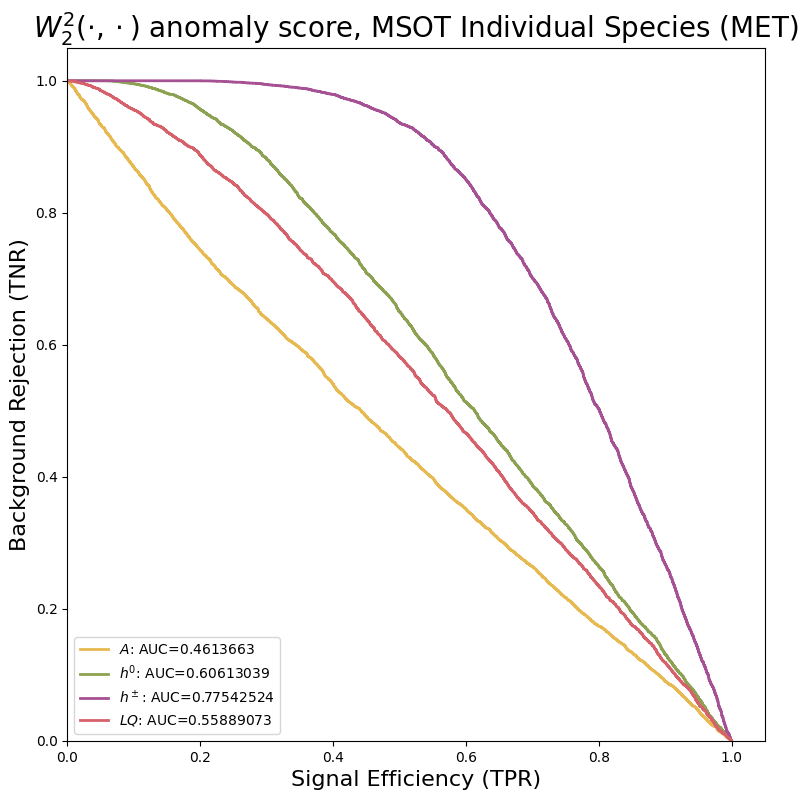

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score, MSOT Individual Species (${\rm MET}$)'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

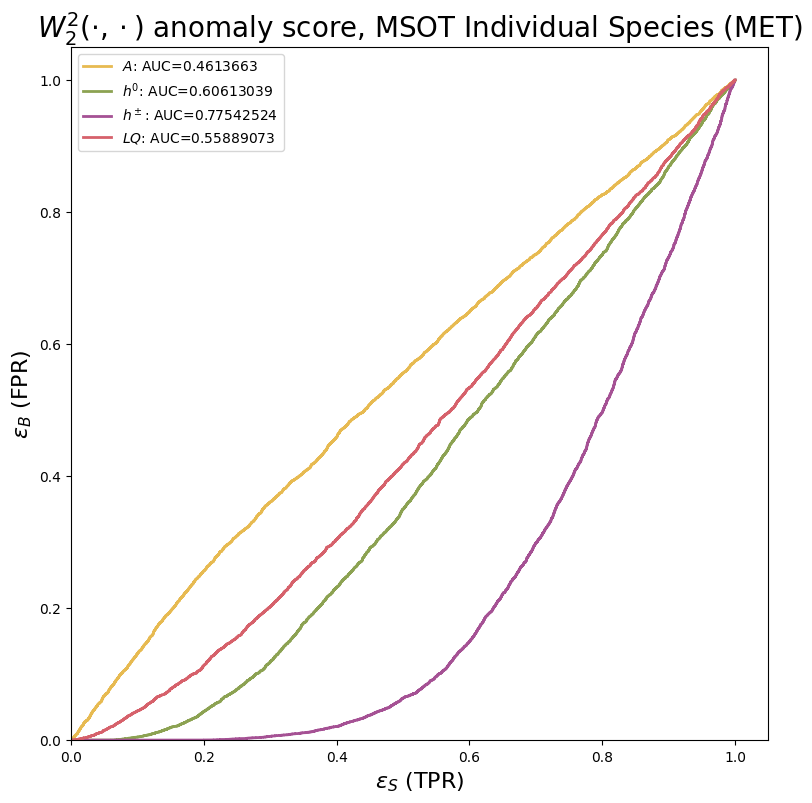

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score, MSOT Individual Species (${\rm MET}$)'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

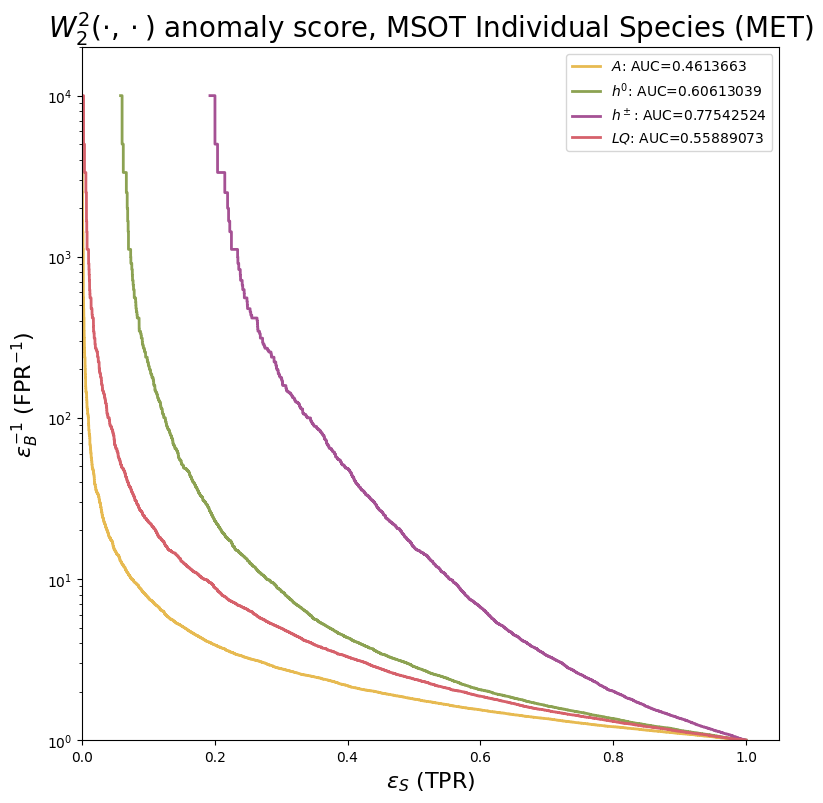

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 2e4)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score, MSOT Individual Species (${\rm MET}$)'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

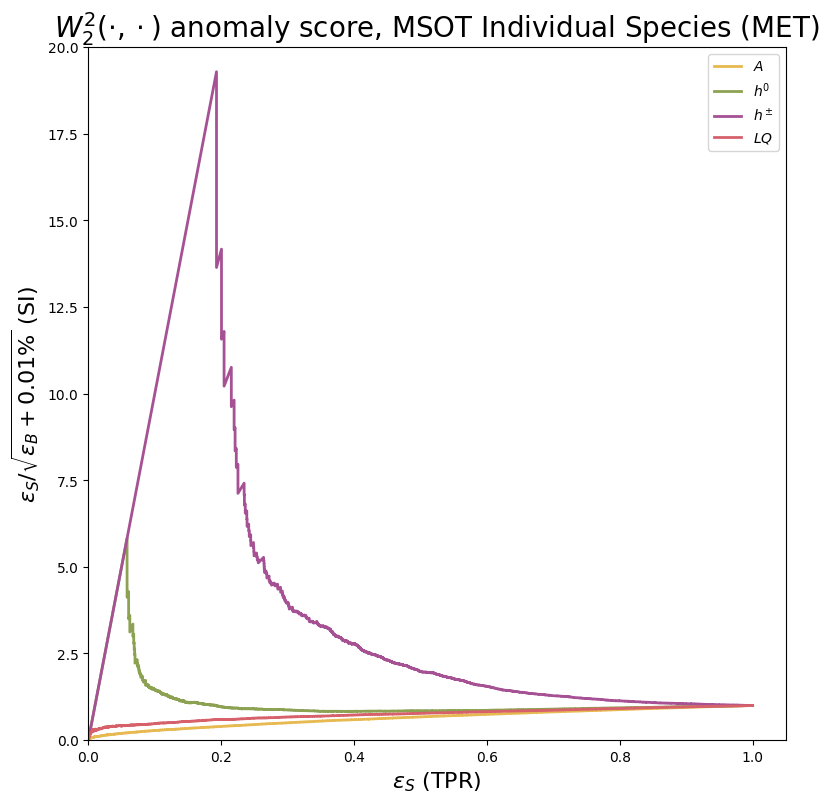

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 20)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score, MSOT Individual Species (${\rm MET}$)'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

In [ ]:
print(tprList[2][0:5])
print(SIList[2][0:5])

[0.000e+00 1.000e-04 1.929e-01 1.929e-01 2.004e-01]
[0.00000000e+00 1.00000000e-02 1.92900000e+01 1.36400898e+01
 1.41704199e+01]


## Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [ ]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [ ]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.4613663
     $h^0$: 0.60613039
   $h^\pm$: 0.77542524
      $LQ$: 0.55889073


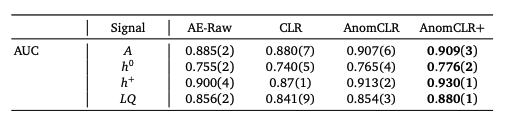

#### Inverse FPR (at TPR = 0.3):

In [ ]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[3258, 1442, 104, 2358]


In [ ]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 2.7731558513588466 (TPR=0.2999)
     $h^0$: 8.467400508044031 (TPR=0.3)
   $h^\pm$: 178.57142857142858 (TPR=0.3004)
      $LQ$: 4.9504950495049505 (TPR=0.2998)


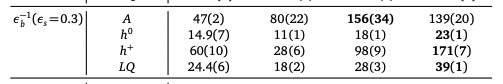

#### SI (at TPR = 0.3):

In [ ]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 0.4993480917886255 (TPR=0.2999)
     $h^0$: 0.8725945907447251 (TPR=0.3)
   $h^\pm$: 3.9788952006233917 (TPR=0.3004)
      $LQ$: 0.6668811958968935 (TPR=0.2998)


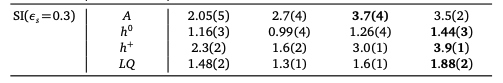

#Species type = $e$

## Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [ ]:
nEvents   = 100

scoreDict = {}

# Generate 2 different samples of nEvents Background events
random_state            = Generator(PCG64(123))
scoreDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, 1:5, 0:3], nEvents, random_state)

random_state            = Generator(PCG64(456))
scoreDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, 1:5, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state          = Generator(PCG64(123))
  scoreDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, 1:5, 0:3], nEvents, random_state)

## Calculate OT anomaly scores

In [ ]:
# nEvents = 100 takes about 16s of wall-clock time
# nEvents = 500 takes about 5 mins of wall-clock time

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTGeneral(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'])

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTGeneral(scoreDict['bkgEvents1'], scoreDict[alias])

In [ ]:
print('scoreDict keys:')
for key in scoreDict.keys():
  print("  ",key)

scoreDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ
   CBB
   wBB
   CBS_sig_A
   wBS_sig_A
   CBS_sig_h0
   wBS_sig_h0
   CBS_sig_hch
   wBS_sig_hch
   CBS_sig_LQ
   wBS_sig_LQ


In [ ]:
#-- Put in convenient list format --#
scoreBkg = scoreDict['wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'wBS_'+alias
  scoreSigList.append(scoreDict[name])

## Plot anomaly scores for all signal types

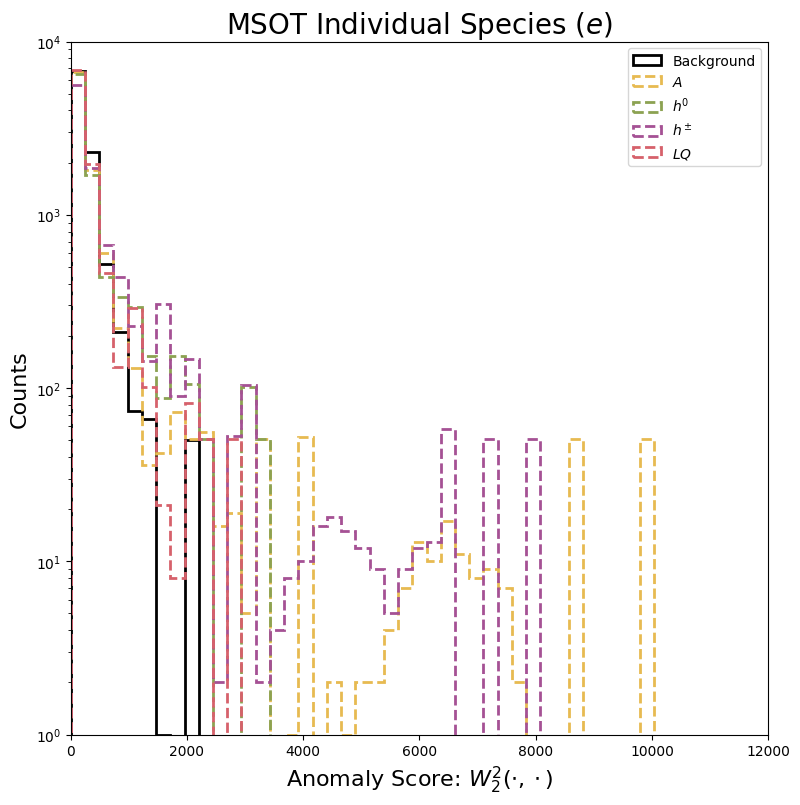

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 12000)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 1e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r'MSOT Individual Species ($e$)'
plotArgDict['nBins']              = 50
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

## Get AUCs, ROC, and SI curves

In [ ]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(scoreBkg, scoreSigList)

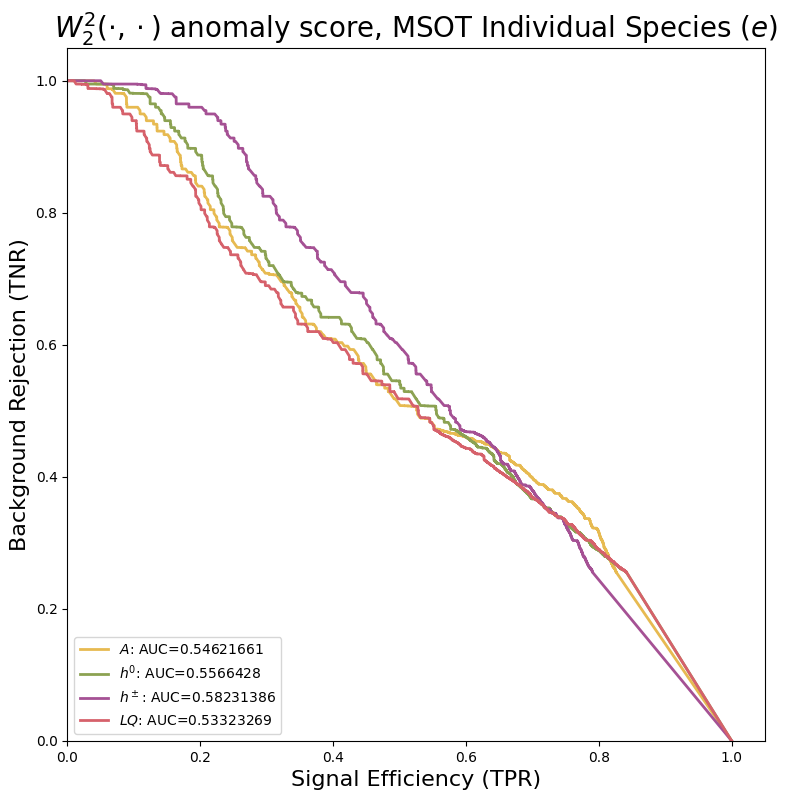

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score, MSOT Individual Species ($e$)'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

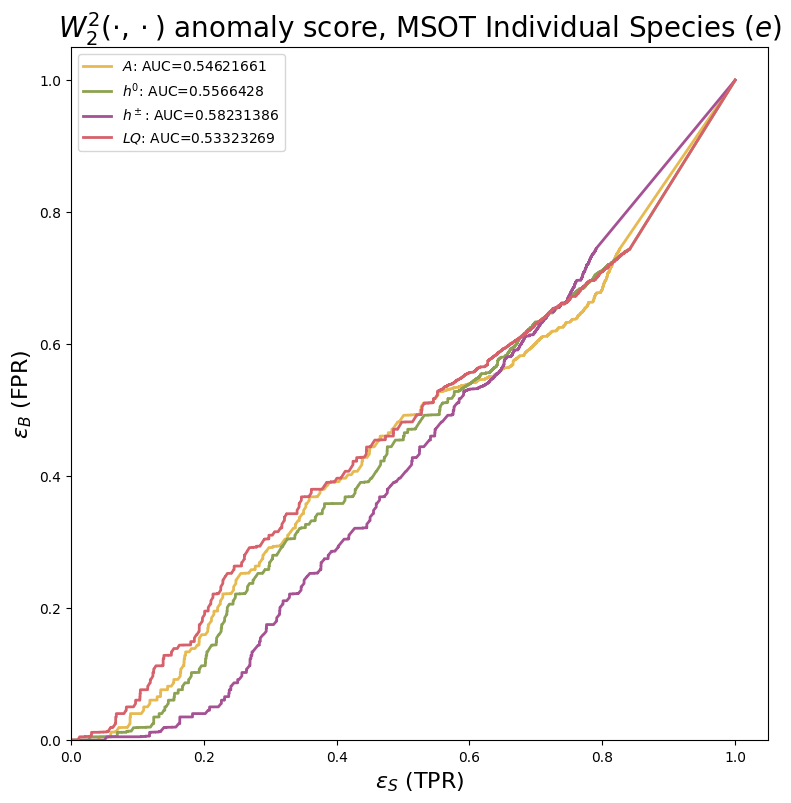

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score, MSOT Individual Species ($e$)'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

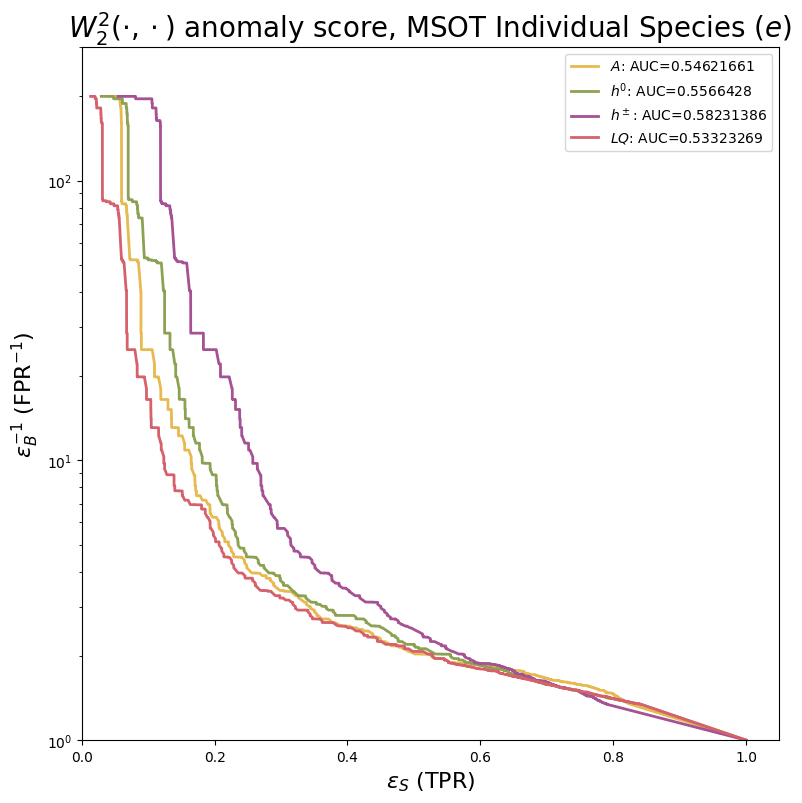

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 3e2)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score, MSOT Individual Species ($e$)'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

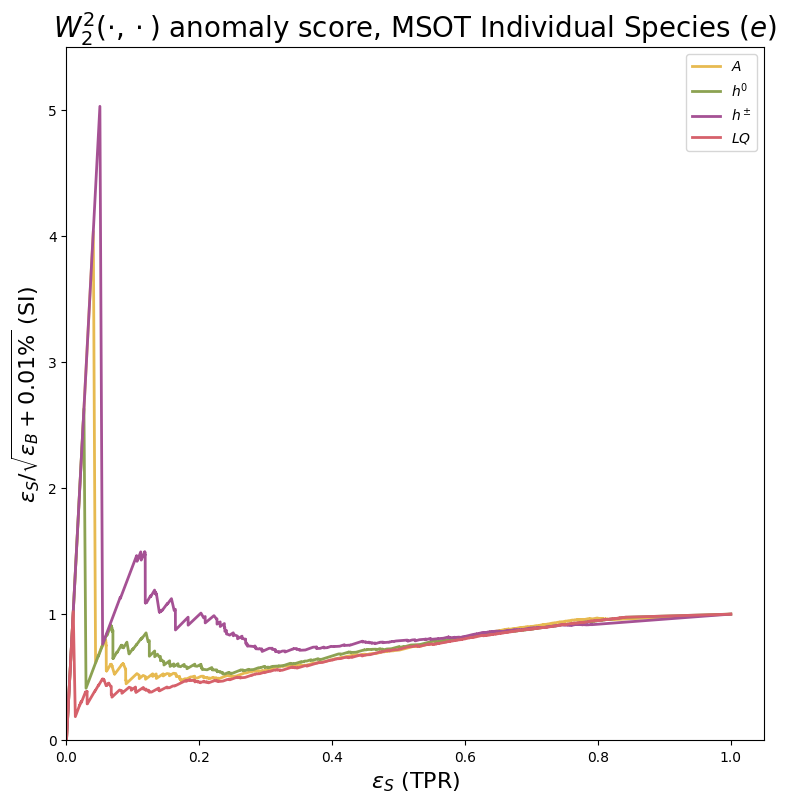

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 5.5)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score, MSOT Individual Species ($e$)'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

In [ ]:
print(tprList[2][0:5])
print(SIList[2][0:5])

[0.     0.0051 0.0153 0.0294 0.0345]
[0.   0.51 1.53 2.94 3.45]


## Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [ ]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [ ]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.54621661
     $h^0$: 0.5566428
   $h^\pm$: 0.58231386
      $LQ$: 0.53323269


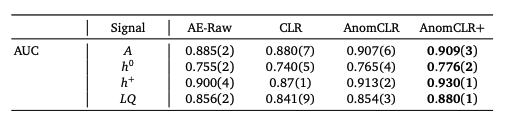

#### Inverse FPR (at TPR = 0.3):

In [ ]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[339, 319, 244, 350]


In [ ]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 3.4281796366129584 (TPR=0.2981)
     $h^0$: 3.7147102526002973 (TPR=0.2996)
   $h^\pm$: 5.711022272986864 (TPR=0.2999)
      $LQ$: 3.2754667540124465 (TPR=0.2981)


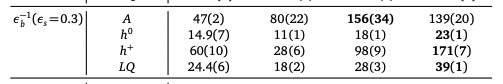

#### SI (at TPR = 0.3):

In [ ]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 0.55184782125186 (TPR=0.2981)
     $h^0$: 0.5773293444189536 (TPR=0.2996)
   $h^\pm$: 0.7164888146099611 (TPR=0.2999)
      $LQ$: 0.5394205154319709 (TPR=0.2981)


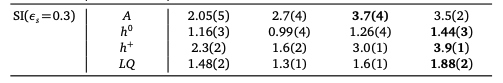

#Species type = $\mu$

## Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [ ]:
nEvents   = 100

scoreDict = {}

# Generate 2 different samples of nEvents Background events
random_state            = Generator(PCG64(123))
scoreDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, 5:9, 0:3], nEvents, random_state)

random_state            = Generator(PCG64(456))
scoreDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, 5:9, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state          = Generator(PCG64(123))
  scoreDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, 5:9, 0:3], nEvents, random_state)

## Calculate OT anomaly scores

In [ ]:
# nEvents = 100 takes about 16s of wall-clock time
# nEvents = 500 takes about 5 mins of wall-clock time

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTGeneral(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'])

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTGeneral(scoreDict['bkgEvents1'], scoreDict[alias])

In [ ]:
print('scoreDict keys:')
for key in scoreDict.keys():
  print("  ",key)

scoreDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ
   CBB
   wBB
   CBS_sig_A
   wBS_sig_A
   CBS_sig_h0
   wBS_sig_h0
   CBS_sig_hch
   wBS_sig_hch
   CBS_sig_LQ
   wBS_sig_LQ


In [ ]:
#-- Put in convenient list format --#
scoreBkg = scoreDict['wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'wBS_'+alias
  scoreSigList.append(scoreDict[name])

## Plot anomaly scores for all signal types

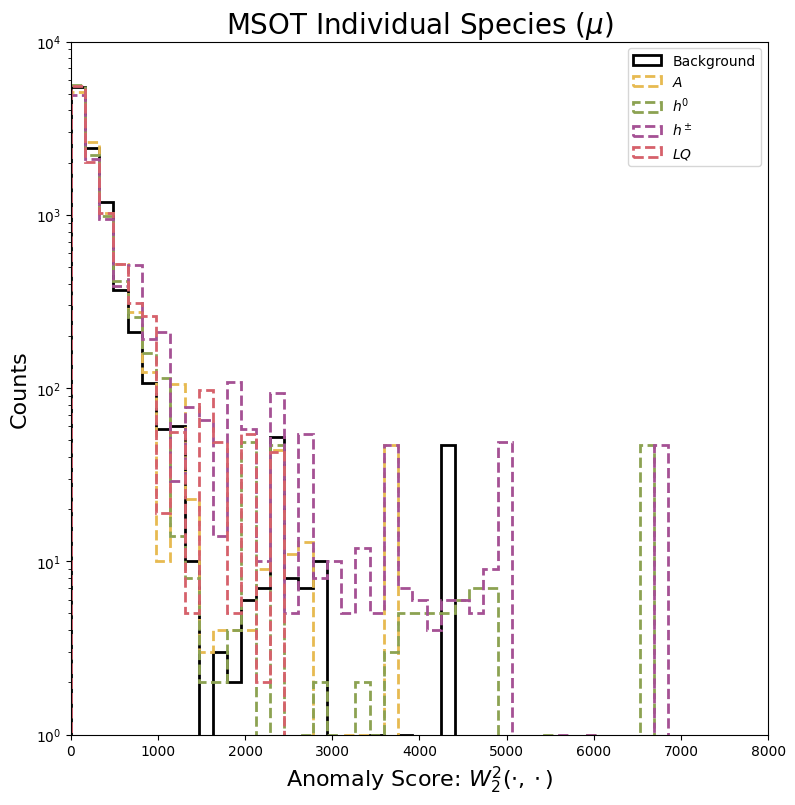

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 8000)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 1e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r'MSOT Individual Species ($\mu$)'
plotArgDict['nBins']              = 50
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

## Get AUCs, ROC, and SI curves

In [ ]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(scoreBkg, scoreSigList)

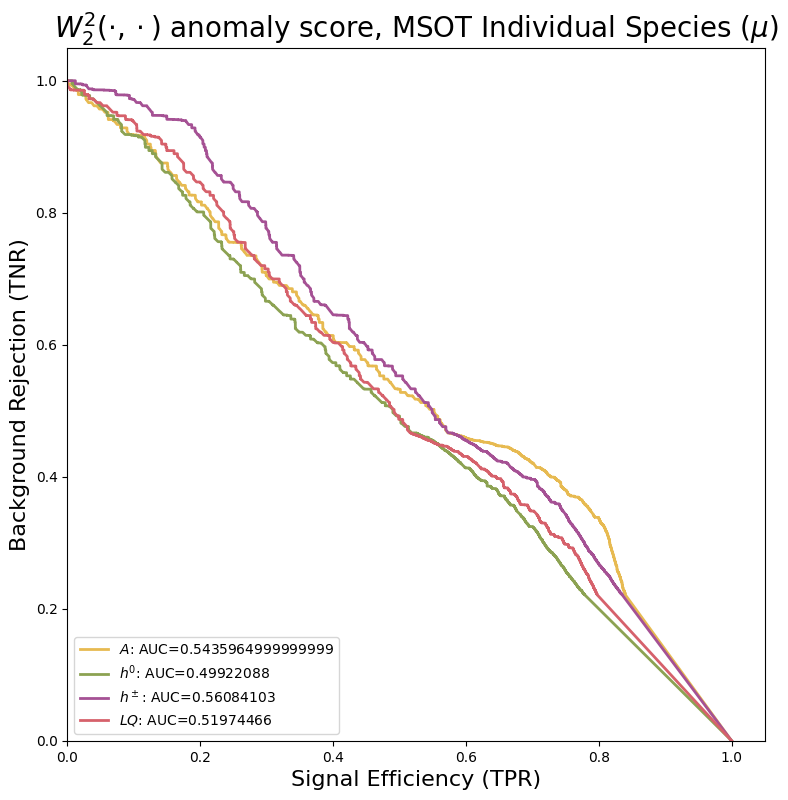

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score, MSOT Individual Species ($\mu$)'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

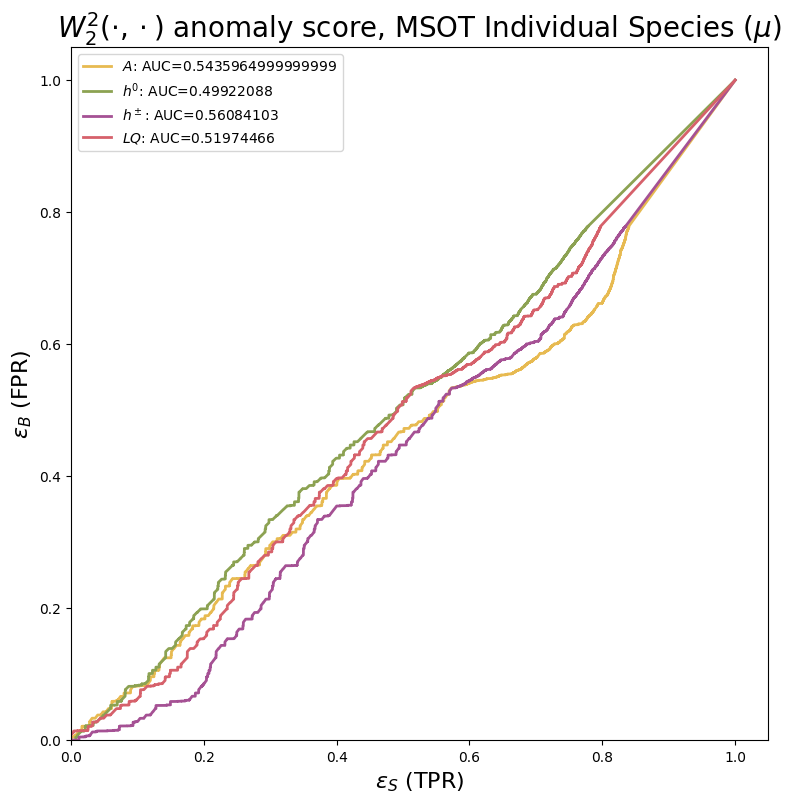

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score, MSOT Individual Species ($\mu$)'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

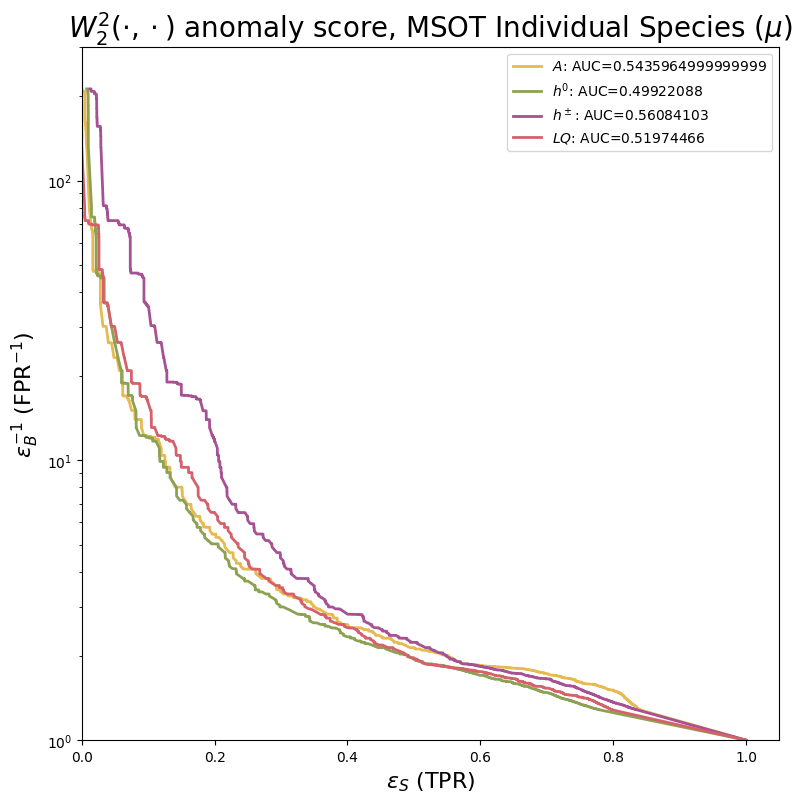

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 3e2)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score, MSOT Individual Species ($\mu$)'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

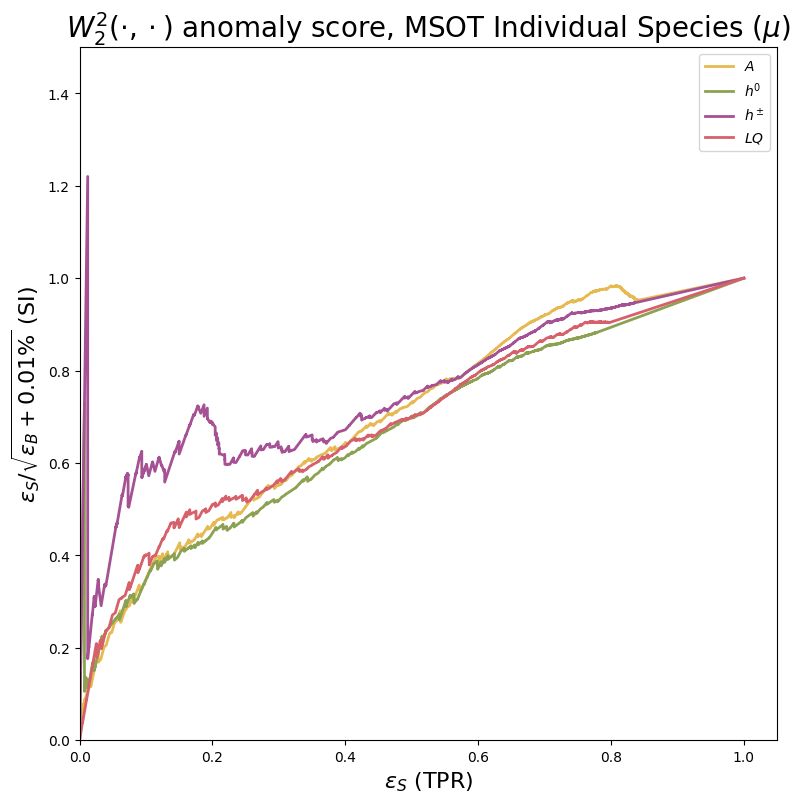

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.5)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score, MSOT Individual Species ($\mu$)'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

In [ ]:
print(tprList[2][0:5])
print(SIList[2][0:5])

[0.     0.0047 0.0051 0.0098 0.0122]
[0.   0.47 0.51 0.98 1.22]


## Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [ ]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [ ]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.5435964999999999
     $h^0$: 0.49922088
   $h^\pm$: 0.56084103
      $LQ$: 0.51974466


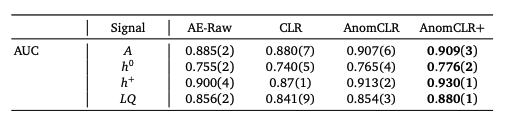

#### Inverse FPR (at TPR = 0.3):

In [ ]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[484, 446, 447, 475]


In [ ]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 3.3863867253640363 (TPR=0.3)
     $h^0$: 3.035822707953855 (TPR=0.2982)
   $h^\pm$: 4.47227191413238 (TPR=0.2996)
      $LQ$: 3.506311360448808 (TPR=0.2977)


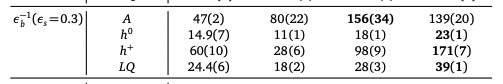

#### SI (at TPR = 0.3):

In [ ]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 0.5519706800961892 (TPR=0.3)
     $h^0$: 0.5194932747581706 (TPR=0.2982)
   $h^\pm$: 0.6334448607383971 (TPR=0.2996)
      $LQ$: 0.5573499273034173 (TPR=0.2977)


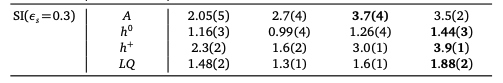

#Species type = ${\rm jet}$

## Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [ ]:
nEvents   = 100

scoreDict = {}

# Generate 2 different samples of nEvents Background events
random_state            = Generator(PCG64(123))
scoreDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, 9:, 0:3], nEvents, random_state)

random_state            = Generator(PCG64(456))
scoreDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, 9:, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state          = Generator(PCG64(123))
  scoreDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, 9:, 0:3], nEvents, random_state)

## Calculate OT anomaly scores

In [ ]:
# nEvents = 100 takes about 16s of wall-clock time
# nEvents = 500 takes about 5 mins of wall-clock time

#-- For background-to-background case --#
scoreDict['CBB'], scoreDict['wBB'] = calcOTGeneral(scoreDict['bkgEvents1'], scoreDict['bkgEvents2'])

#-- For background-to-signal case --#
for alias in sigAliasList:
  name_C = 'CBS_'+alias
  name_w = 'wBS_'+alias

  scoreDict[name_C], scoreDict[name_w] = calcOTGeneral(scoreDict['bkgEvents1'], scoreDict[alias])

In [ ]:
print('scoreDict keys:')
for key in scoreDict.keys():
  print("  ",key)

scoreDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ
   CBB
   wBB
   CBS_sig_A
   wBS_sig_A
   CBS_sig_h0
   wBS_sig_h0
   CBS_sig_hch
   wBS_sig_hch
   CBS_sig_LQ
   wBS_sig_LQ


In [ ]:
#-- Put in convenient list format --#
scoreBkg = scoreDict['wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'wBS_'+alias
  scoreSigList.append(scoreDict[name])

## Plot anomaly scores for all signal types

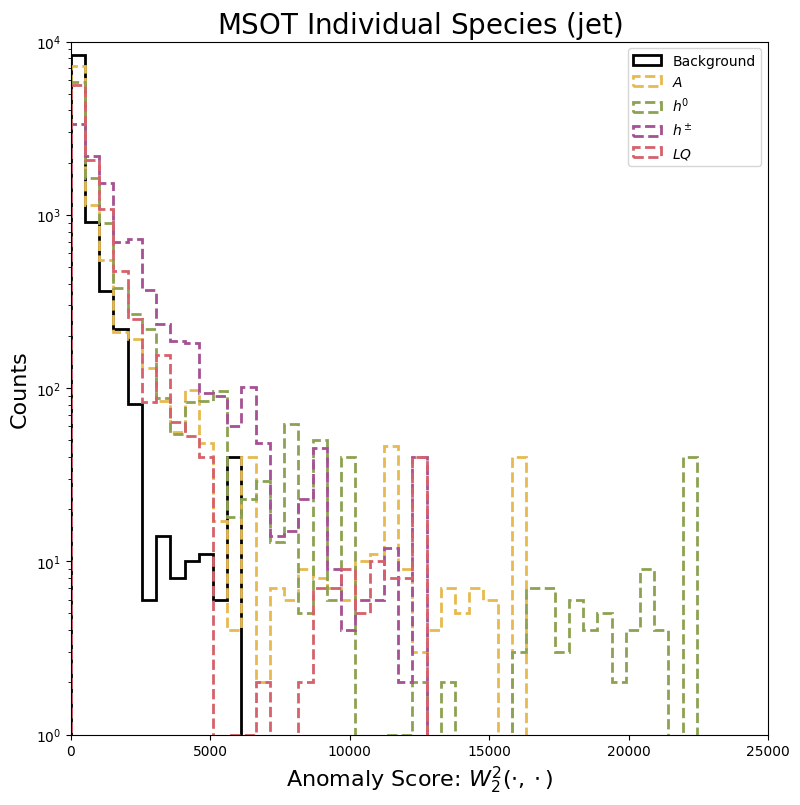

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 25000)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 1e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r'MSOT Individual Species (${\rm jet}$)'
plotArgDict['nBins']              = 50
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

## Get AUCs, ROC, and SI curves

In [ ]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(scoreBkg, scoreSigList)

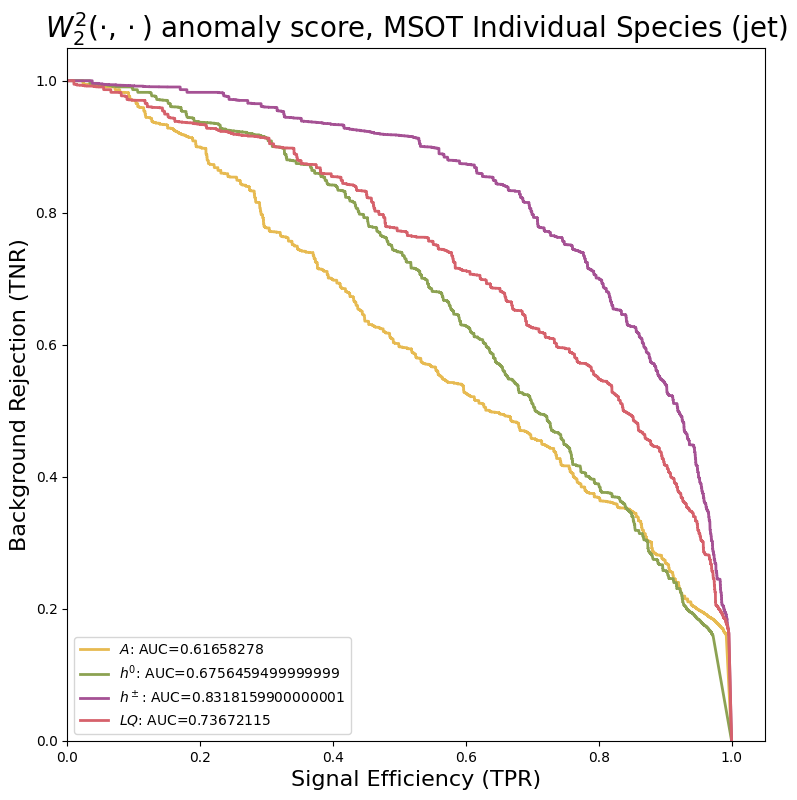

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score, MSOT Individual Species (${\rm jet}$)'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

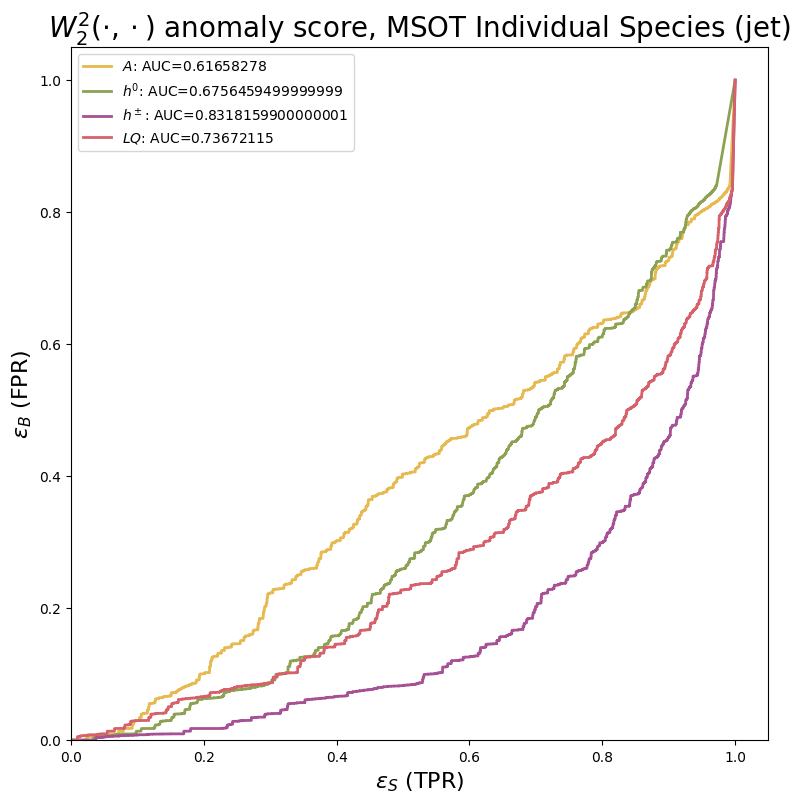

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score, MSOT Individual Species (${\rm jet}$)'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

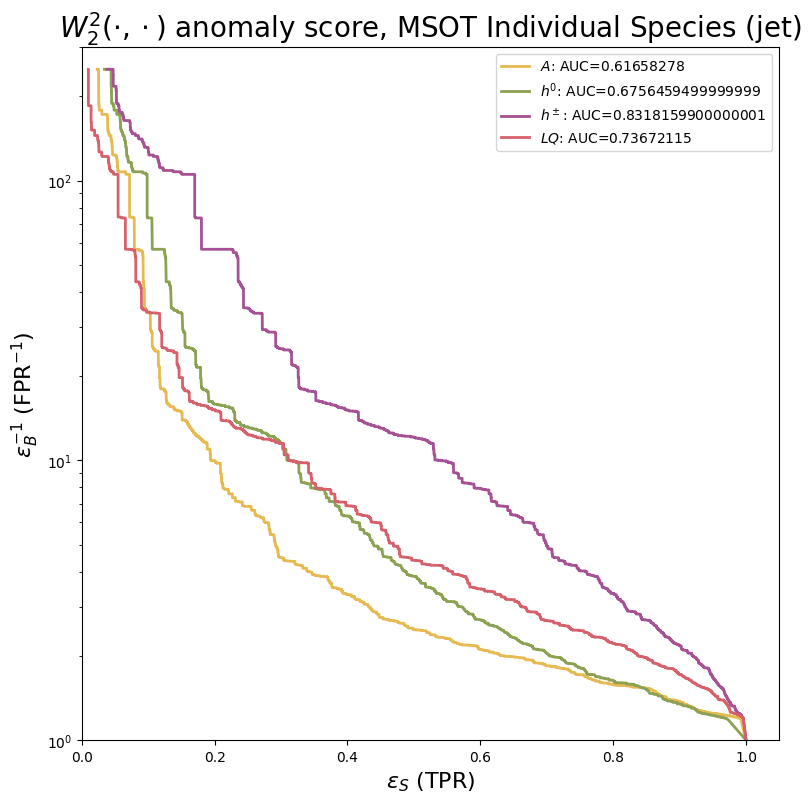

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 3e2)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score, MSOT Individual Species (${\rm jet}$)'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

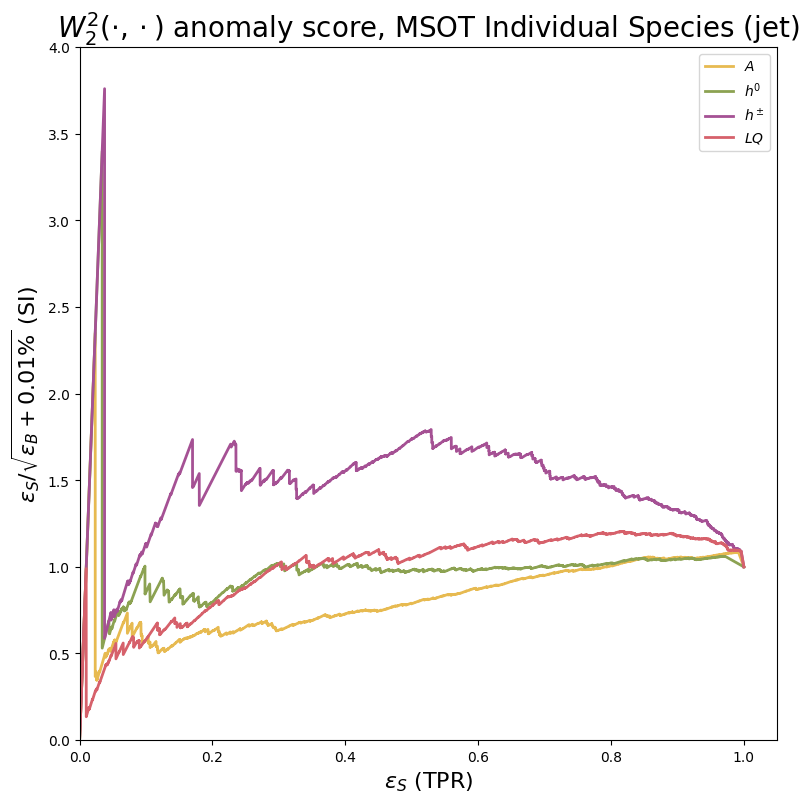

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 4)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score, MSOT Individual Species (${\rm jet}$)'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

In [ ]:
print(tprList[2][0:5])
print(SIList[2][0:5])

[0.     0.004  0.0081 0.0121 0.0176]
[0.   0.4  0.81 1.21 1.76]


## Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [ ]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [ ]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.61658278
     $h^0$: 0.6756459499999999
   $h^\pm$: 0.8318159900000001
      $LQ$: 0.73672115


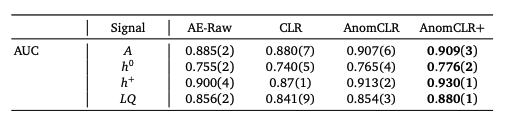

#### Inverse FPR (at TPR = 0.3):

In [ ]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[978, 641, 285, 653]


In [ ]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 4.482294935006723 (TPR=0.2996)
     $h^0$: 11.52073732718894 (TPR=0.3002)
   $h^\pm$: 25.06265664160401 (TPR=0.2983)
      $LQ$: 11.49425287356322 (TPR=0.2987)


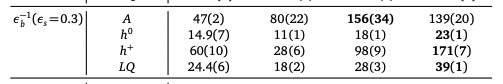

#### SI (at TPR = 0.3):

In [ ]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 0.6341539674876179 (TPR=0.2996)
     $h^0$: 1.0183587508606904 (TPR=0.3002)
   $h^\pm$: 1.4915 (TPR=0.2983)
      $LQ$: 1.0121063393983298 (TPR=0.2987)


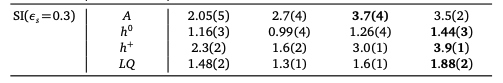

#Proxy for Multispecies OT (MSOT): Weighted combination of individual species OT

# wList = [1., 1., 1., 1.]

## Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [ ]:
nEvents   = 100

trimmedDataDict = {}

# Generate 2 different samples of nEvents Background events
random_state                  = Generator(PCG64(123))
trimmedDataDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

random_state                  = Generator(PCG64(456))
trimmedDataDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state                = Generator(PCG64(123))
  trimmedDataDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, :, 0:3], nEvents, random_state)

In [ ]:
print('trimmedDataDict keys:')
for key in trimmedDataDict.keys():
  print("  ",key)

trimmedDataDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ


## Calculate OT anomaly scores

In [ ]:
scoreDict = calcIndividualOTScores(trimmedDataDict, sigAliasList, speciesList=['MET', 'e', 'mu', 'jet'])

In [ ]:
scoreDict_new = calcWeightedComboOTscores(scoreDict, wList=[1., 1., 1., 1.])

In [ ]:
print('scoreDict_new keys:')
for key in scoreDict_new.keys():
  print("  ",key)
  for subkey in scoreDict_new[key].keys():
    print("    ",subkey)

print("")
print("scoreDict_new[MET][wBB].shape", scoreDict_new['MET']['wBB'].shape)

scoreDict_new keys:
   MET
     wBB
     wBS_sig_A
     wBS_sig_h0
     wBS_sig_hch
     wBS_sig_LQ
   e
     wBB
     wBS_sig_A
     wBS_sig_h0
     wBS_sig_hch
     wBS_sig_LQ
   mu
     wBB
     wBS_sig_A
     wBS_sig_h0
     wBS_sig_hch
     wBS_sig_LQ
   jet
     wBB
     wBS_sig_A
     wBS_sig_h0
     wBS_sig_hch
     wBS_sig_LQ
   combo
     combo_wBB
     combo_wBS_sig_A
     combo_wBS_sig_h0
     combo_wBS_sig_hch
     combo_wBS_sig_LQ

scoreDict_new[MET][wBB].shape (10000,)


In [ ]:
#-- Put in convenient list format --#
scoreBkg = scoreDict_new['combo']['combo_wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'combo_wBS_'+alias
  scoreSigList.append(scoreDict_new['combo'][name])

## Plot anomaly scores for all signal types

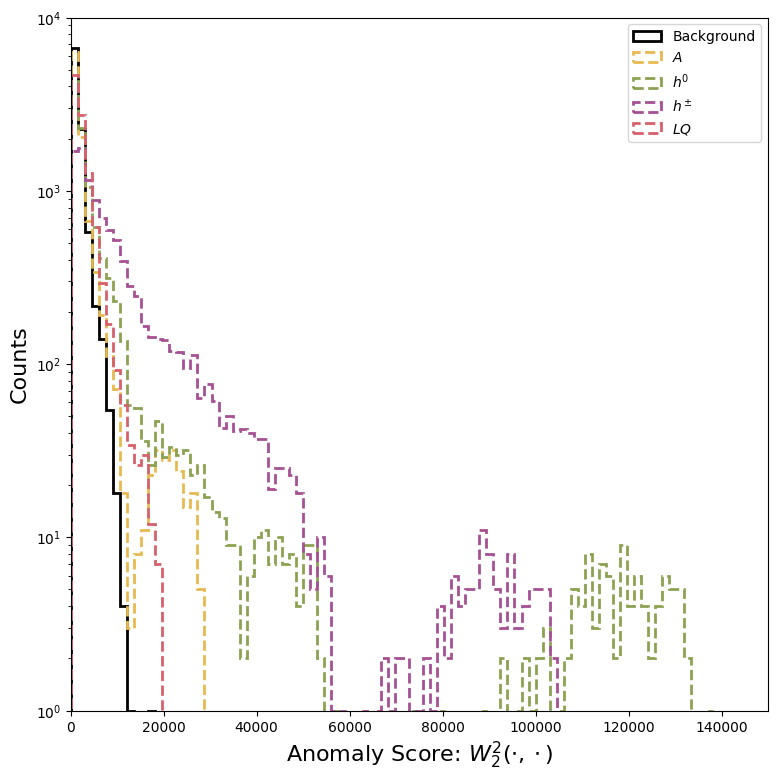

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 150000)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 1e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

## Get AUCs, ROC, and SI curves

In [ ]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(scoreBkg, scoreSigList)

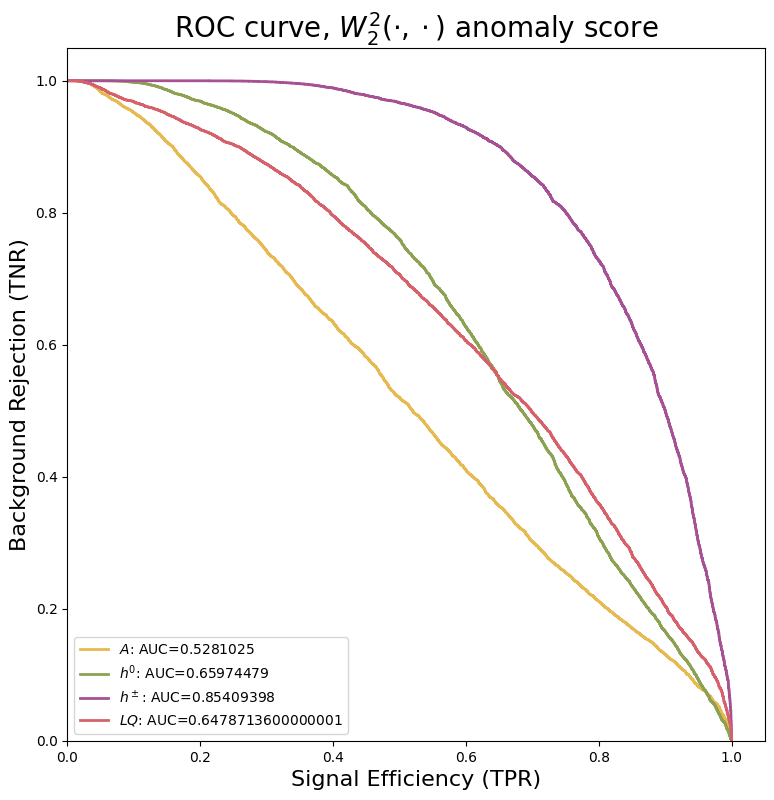

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

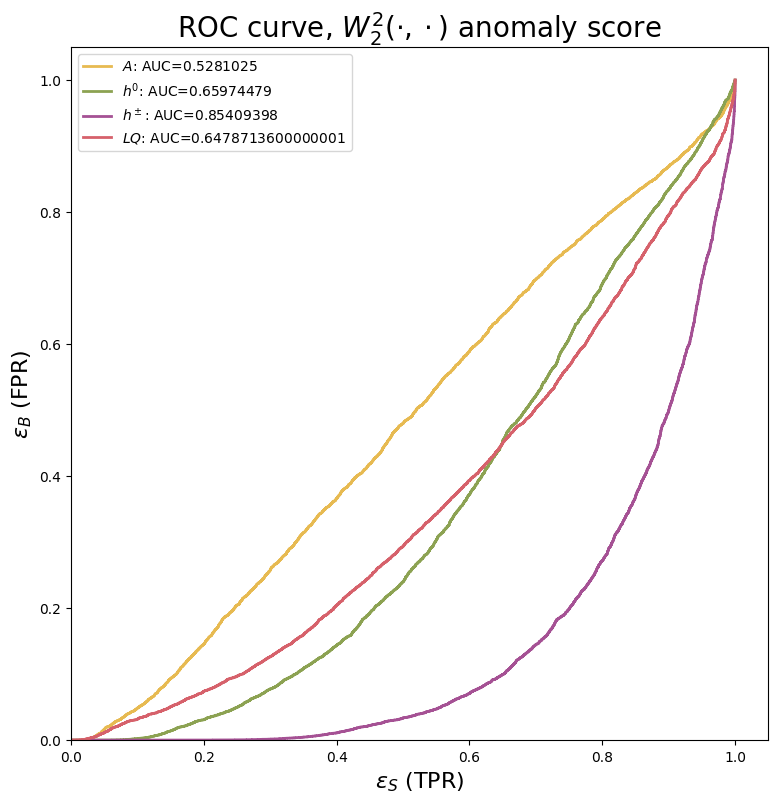

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

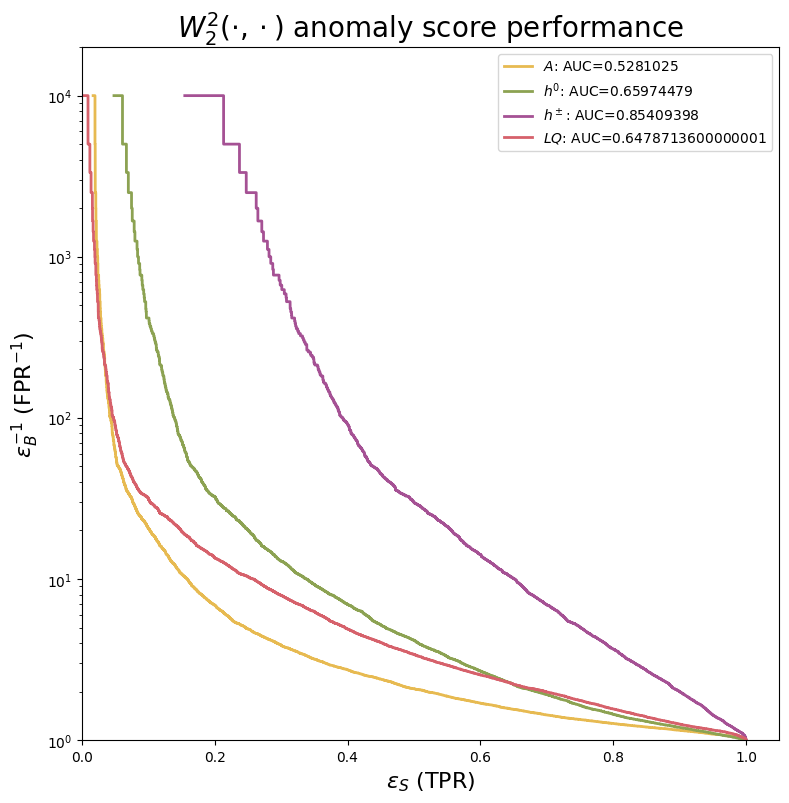

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 2e4)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score performance'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

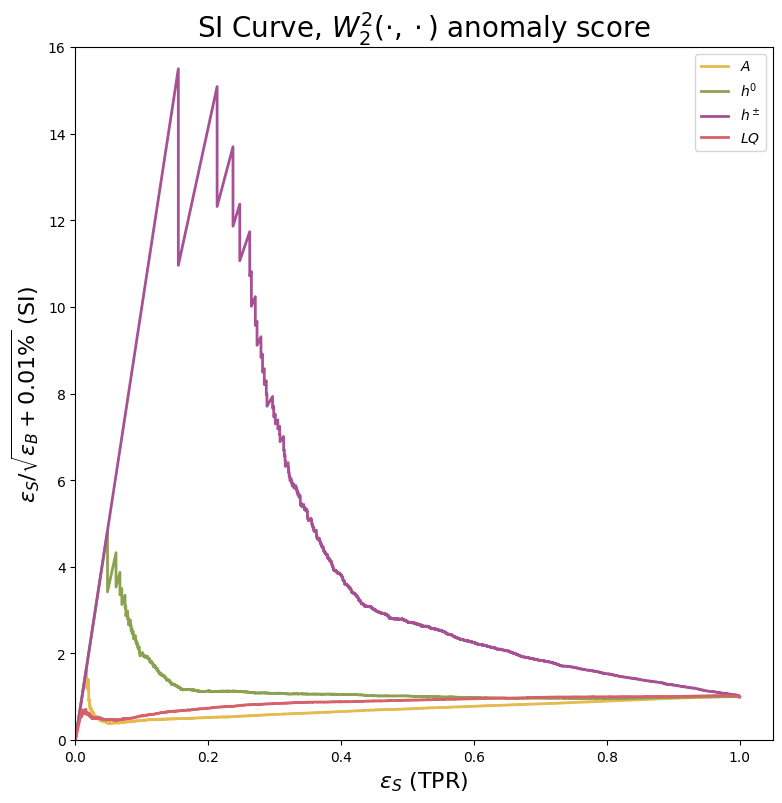

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 16)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'SI Curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

In [ ]:
print(tprList[2][0:5])
print(SIList[2][0:5])

[0.000e+00 1.000e-04 1.550e-01 1.550e-01 2.134e-01]
[0.00000000e+00 1.00000000e-02 1.55000000e+01 1.09601551e+01
 1.50896587e+01]


## Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [ ]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [ ]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.5281025
     $h^0$: 0.65974479
   $h^\pm$: 0.85409398
      $LQ$: 0.6478713600000001


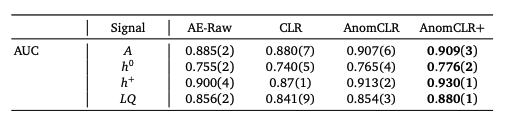

#### Inverse FPR (at TPR = 0.3):

In [ ]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[2670, 1134, 32, 1774]


In [ ]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 3.8895371450797356 (TPR=0.3)
     $h^0$: 12.919896640826874 (TPR=0.2998)
   $h^\pm$: 666.6666666666666 (TPR=0.301)
      $LQ$: 7.936507936507937 (TPR=0.3001)


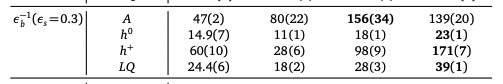

#### SI (at TPR = 0.3):

In [ ]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 0.5915422550438243 (TPR=0.3)
     $h^0$: 1.0769133909525423 (TPR=0.2998)
   $h^\pm$: 7.5249999999999995 (TPR=0.301)
      $LQ$: 0.8451006819127467 (TPR=0.3001)


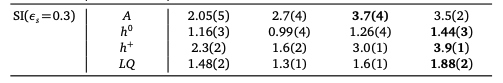

#wList = [1., 0., 0., 1.]

## Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [ ]:
nEvents   = 100

trimmedDataDict = {}

# Generate 2 different samples of nEvents Background events
random_state                  = Generator(PCG64(123))
trimmedDataDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

random_state                  = Generator(PCG64(456))
trimmedDataDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state                = Generator(PCG64(123))
  trimmedDataDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, :, 0:3], nEvents, random_state)

In [ ]:
print('trimmedDataDict keys:')
for key in trimmedDataDict.keys():
  print("  ",key)

trimmedDataDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ


## Calculate OT anomaly scores

In [ ]:
scoreDict = calcIndividualOTScores(trimmedDataDict, sigAliasList, speciesList=['MET', 'e', 'mu', 'jet'])

In [ ]:
scoreDict_new = calcWeightedComboOTscores(scoreDict, wList=[1., 0., 0., 1.])

In [ ]:
print('scoreDict_new keys:')
for key in scoreDict_new.keys():
  print("  ",key)
  for subkey in scoreDict_new[key].keys():
    print("    ",subkey)

print("")
print("scoreDict_new[MET][wBB].shape", scoreDict_new['MET']['wBB'].shape)

scoreDict_new keys:
   MET
     wBB
     wBS_sig_A
     wBS_sig_h0
     wBS_sig_hch
     wBS_sig_LQ
   e
     wBB
     wBS_sig_A
     wBS_sig_h0
     wBS_sig_hch
     wBS_sig_LQ
   mu
     wBB
     wBS_sig_A
     wBS_sig_h0
     wBS_sig_hch
     wBS_sig_LQ
   jet
     wBB
     wBS_sig_A
     wBS_sig_h0
     wBS_sig_hch
     wBS_sig_LQ
   combo
     combo_wBB
     combo_wBS_sig_A
     combo_wBS_sig_h0
     combo_wBS_sig_hch
     combo_wBS_sig_LQ

scoreDict_new[MET][wBB].shape (10000,)


In [ ]:
#-- Put in convenient list format --#
scoreBkg = scoreDict_new['combo']['combo_wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'combo_wBS_'+alias
  scoreSigList.append(scoreDict_new['combo'][name])

## Plot anomaly scores for all signal types

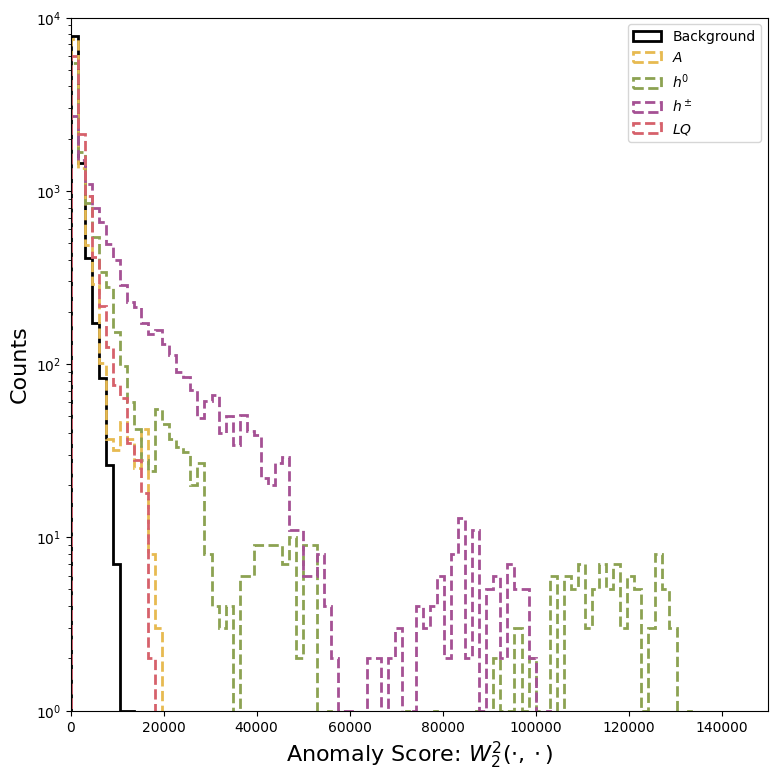

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 150000)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 1e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

## Get AUCs, ROC, and SI curves

In [ ]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(scoreBkg, scoreSigList)

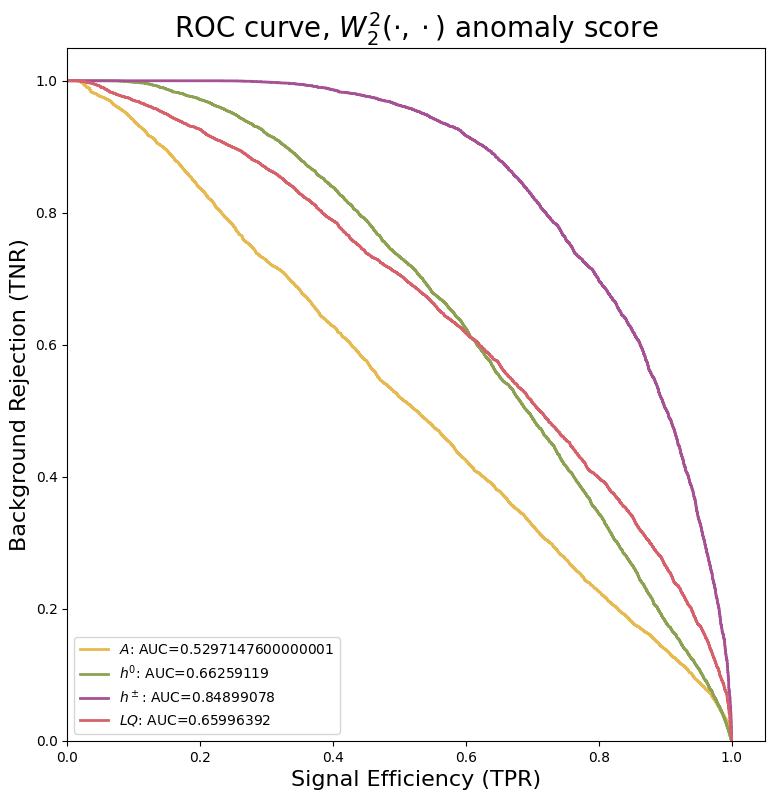

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

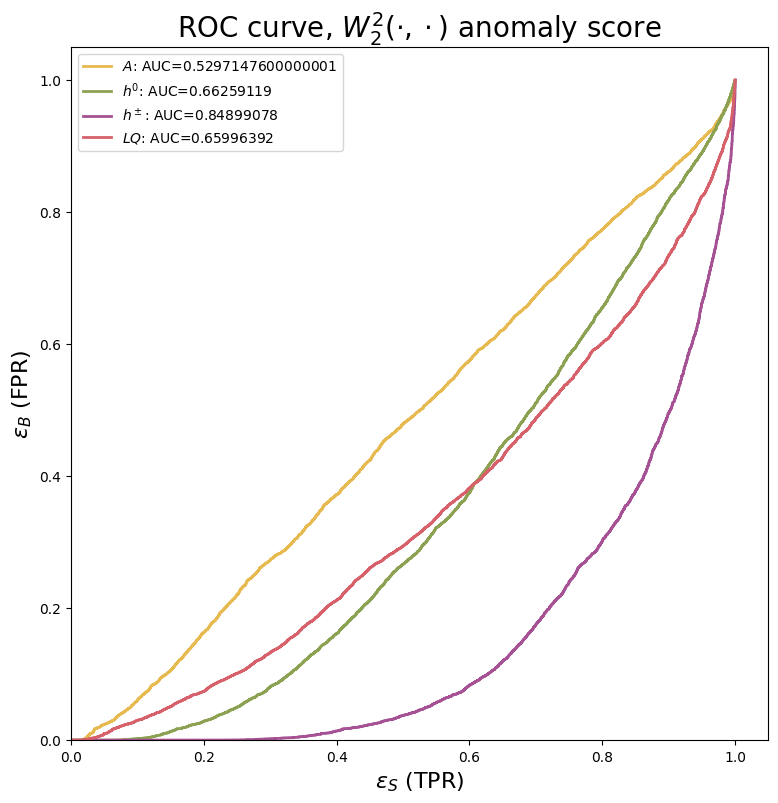

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

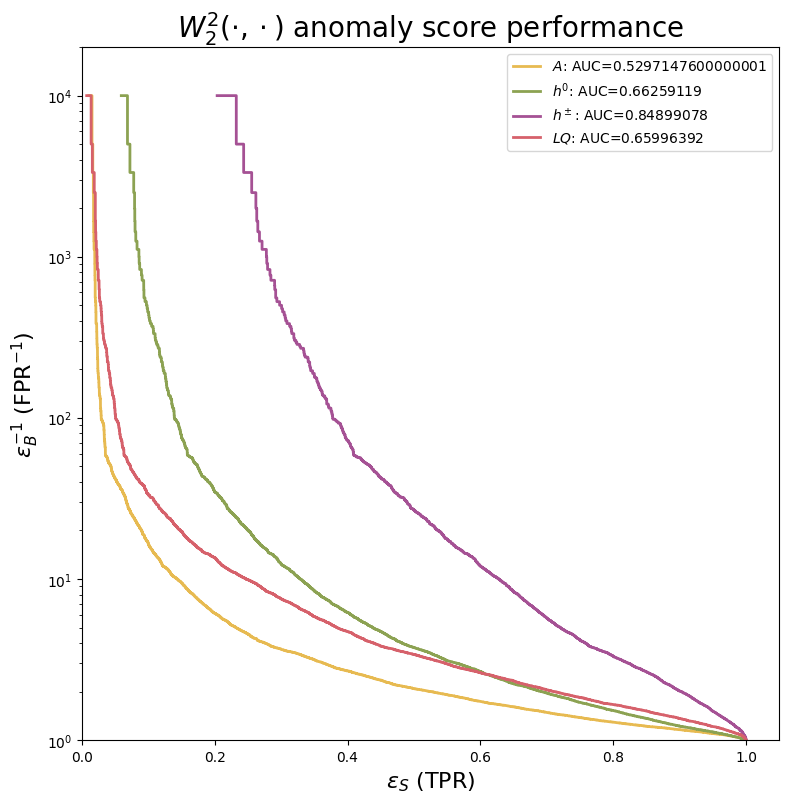

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 2e4)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score performance'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

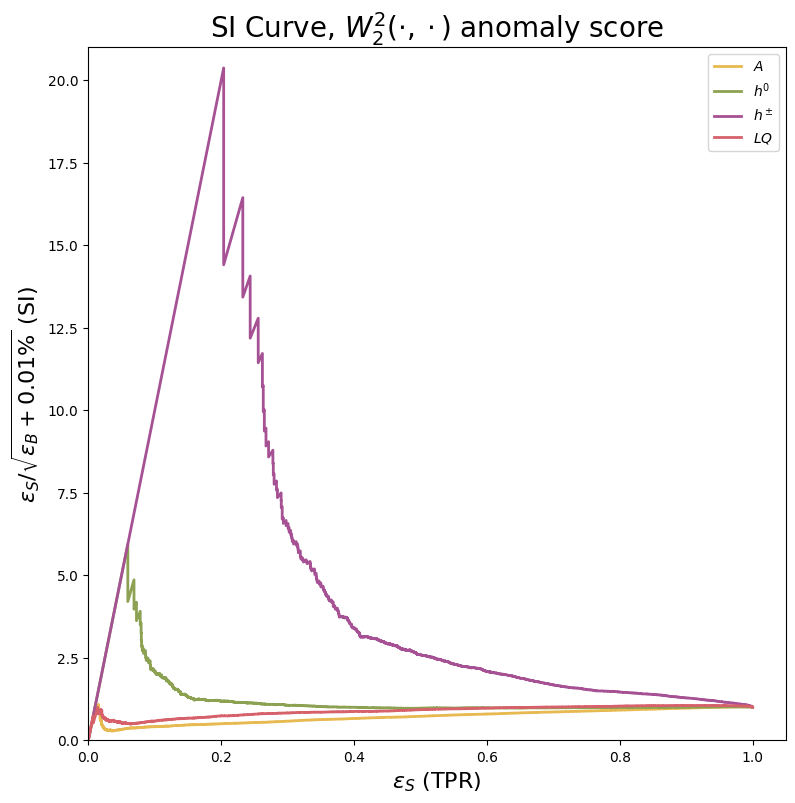

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 21)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'SI Curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

In [ ]:
print(tprList[2][0:5])
print(SIList[2][0:5])

[0.000e+00 1.000e-04 2.037e-01 2.037e-01 2.325e-01]
[0.00000000e+00 1.00000000e-02 2.03700000e+01 1.44037651e+01
 1.64402327e+01]


## Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [ ]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [ ]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.5297147600000001
     $h^0$: 0.66259119
   $h^\pm$: 0.84899078
      $LQ$: 0.65996392


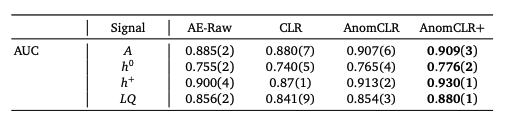

#### Inverse FPR (at TPR = 0.3):

In [ ]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[2744, 1136, 40, 1764]


In [ ]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 3.6697247706422016 (TPR=0.3)
     $h^0$: 12.406947890818858 (TPR=0.3)
   $h^\pm$: 500.0 (TPR=0.3007)
      $LQ$: 7.547169811320754 (TPR=0.3001)


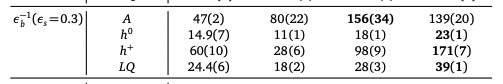

#### SI (at TPR = 0.3):

In [ ]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 0.5745903513810688 (TPR=0.3)
     $h^0$: 1.0560500157131443 (TPR=0.3)
   $h^\pm$: 6.561811959396292 (TPR=0.3007)
      $LQ$: 0.8241271720898251 (TPR=0.3001)


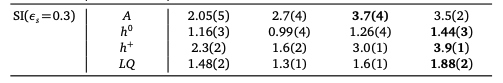

#wList = [1., 2., 2., 1.]

## Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [ ]:
nEvents   = 100

trimmedDataDict = {}

# Generate 2 different samples of nEvents Background events
random_state                  = Generator(PCG64(123))
trimmedDataDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

random_state                  = Generator(PCG64(456))
trimmedDataDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state                = Generator(PCG64(123))
  trimmedDataDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, :, 0:3], nEvents, random_state)

In [ ]:
print('trimmedDataDict keys:')
for key in trimmedDataDict.keys():
  print("  ",key)

trimmedDataDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ


## Calculate OT anomaly scores

In [ ]:
scoreDict = calcIndividualOTScores(trimmedDataDict, sigAliasList, speciesList=['MET', 'e', 'mu', 'jet'])

In [ ]:
scoreDict_new = calcWeightedComboOTscores(scoreDict, wList=[1., 2., 2., 1.])

In [ ]:
print('scoreDict_new keys:')
for key in scoreDict_new.keys():
  print("  ",key)
  for subkey in scoreDict_new[key].keys():
    print("    ",subkey)

print("")
print("scoreDict_new[MET][wBB].shape", scoreDict_new['MET']['wBB'].shape)

scoreDict_new keys:
   MET
     wBB
     wBS_sig_A
     wBS_sig_h0
     wBS_sig_hch
     wBS_sig_LQ
   e
     wBB
     wBS_sig_A
     wBS_sig_h0
     wBS_sig_hch
     wBS_sig_LQ
   mu
     wBB
     wBS_sig_A
     wBS_sig_h0
     wBS_sig_hch
     wBS_sig_LQ
   jet
     wBB
     wBS_sig_A
     wBS_sig_h0
     wBS_sig_hch
     wBS_sig_LQ
   combo
     combo_wBB
     combo_wBS_sig_A
     combo_wBS_sig_h0
     combo_wBS_sig_hch
     combo_wBS_sig_LQ

scoreDict_new[MET][wBB].shape (10000,)


In [ ]:
#-- Put in convenient list format --#
scoreBkg = scoreDict_new['combo']['combo_wBB']
scoreSigList = []
for alias in sigAliasList:
  name = 'combo_wBS_'+alias
  scoreSigList.append(scoreDict_new['combo'][name])

## Plot anomaly scores for all signal types

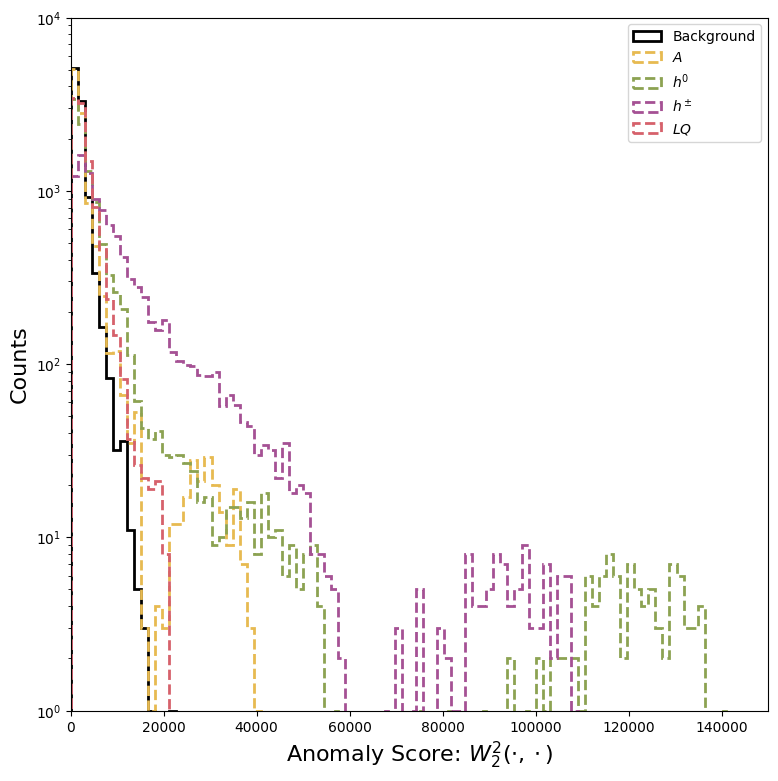

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']             = (3,3)
plotArgDict['xAxisLims']          = (0, 150000)
plotArgDict['xLabel']             = r'Anomaly Score: $W_2^2(\cdot, \cdot)$'
plotArgDict['yAxisLims']          = (1, 1e4)
plotArgDict['yLabel']             = r'Counts'
plotArgDict['title']              = r''
plotArgDict['nBins']              = 100
plotArgDict['logY']               = True
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotScoreHists(scoreBkg, scoreSigList, plotArgDict)

## Get AUCs, ROC, and SI curves

In [ ]:
aucList, fprList, tprList, SIList, fprInvList = calcROCmetrics(scoreBkg, scoreSigList)

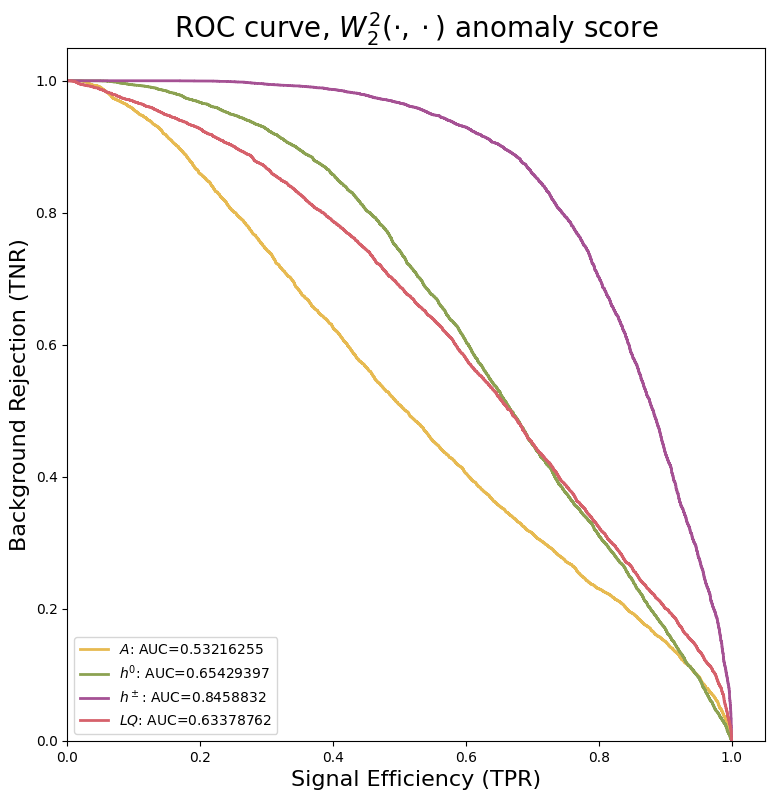

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'Signal Efficiency (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'Background Rejection (TNR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict)

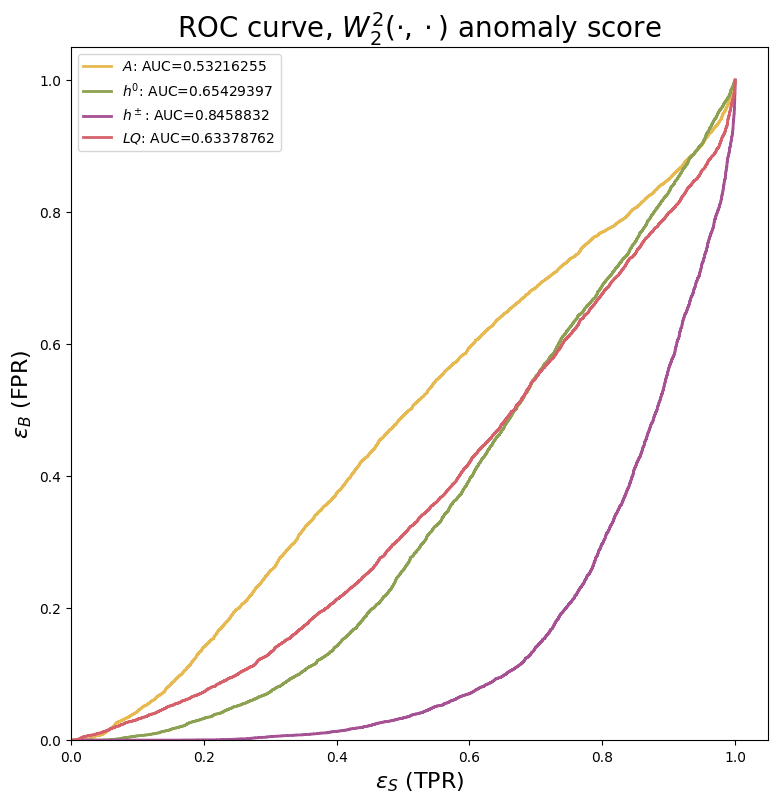

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 1.05)
plotArgDict['yLabel']    = r'$\epsilon_B$ (FPR)'
plotArgDict['title']     = r'ROC curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotROCcurve(aucList, fprList, tprList, plotArgDict, TYPE='Alt')

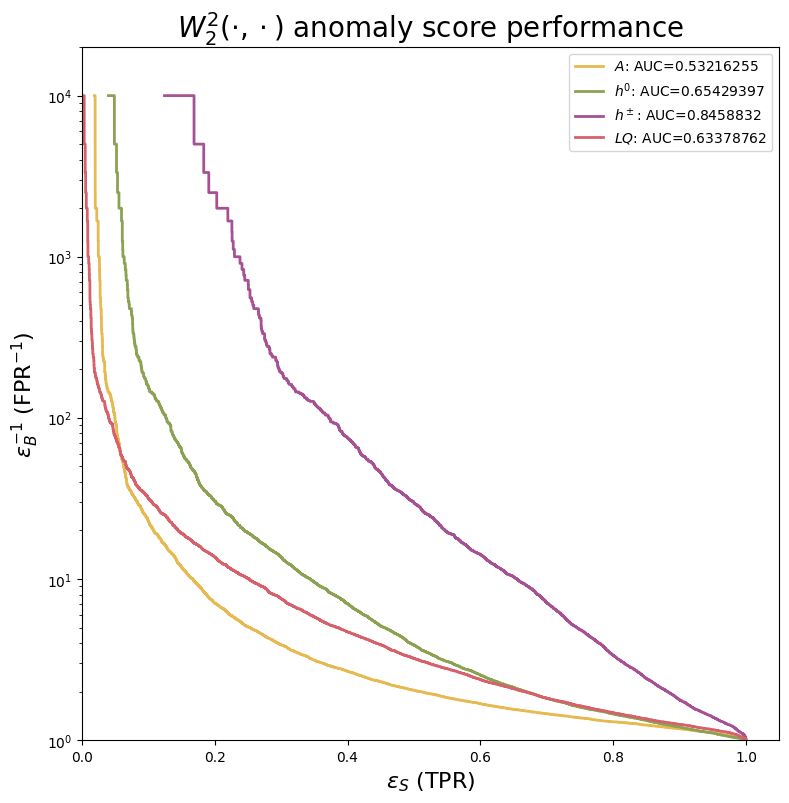

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (1, 2e4)
plotArgDict['yLabel']    = r'$\epsilon_B^{-1}$ (FPR$^{-1}$)'
plotArgDict['title']     = r'$W_2^2(\cdot, \cdot)$ anomaly score performance'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotInvROCcurve(aucList, fprInvList, tprList, plotArgDict)

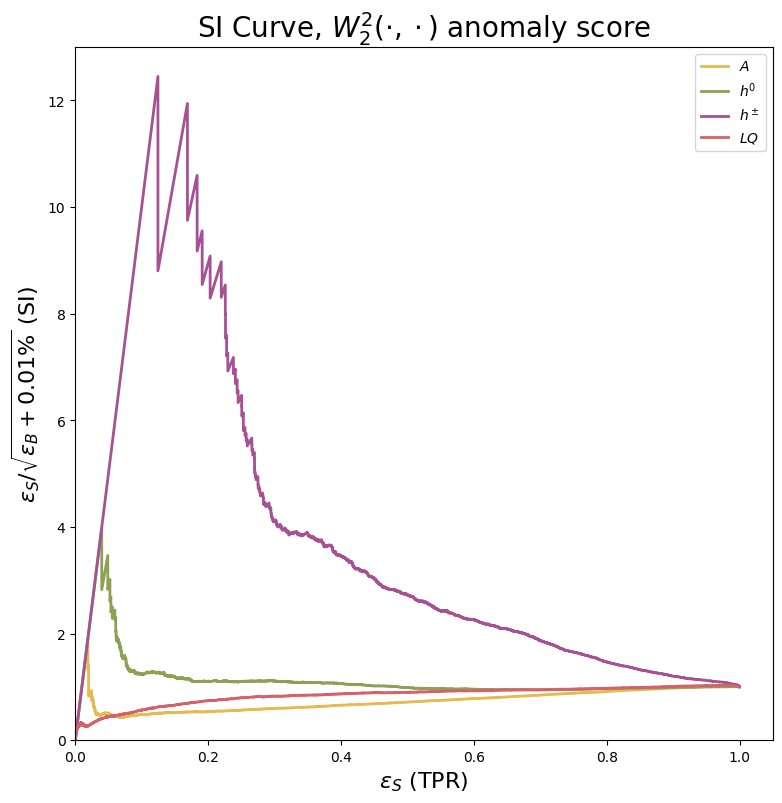

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (0, 1.05)
plotArgDict['xLabel']    = r'$\epsilon_S$ (TPR)'
plotArgDict['yAxisLims'] = (0, 13)
plotArgDict['yLabel']    = r'$\epsilon_S/ \sqrt{\epsilon_B + 0.01\%}$ (SI)'
plotArgDict['title']     = r'SI Curve, $W_2^2(\cdot, \cdot)$ anomaly score'
plotArgDict['CMAP']               = SIGNAL_COLOR_ARR
plotArgDict['sigObjectNameList']  = [r'$A$', r'$h^0$', r'$h^\pm$', r'$LQ$']

plotSIcurve(tprList, SIList, plotArgDict)

In [ ]:
print(tprList[2][0:5])
print(SIList[2][0:5])

[0.000e+00 1.000e-04 1.245e-01 1.245e-01 1.689e-01]
[0.00000000e+00 1.00000000e-02 1.24500000e+01 8.80347943e+00
 1.19430335e+01]


## Comparing performance with recent work (AnomalyCLR)

We can compare this to the benchmarks set by this [recent paper](https://arxiv.org/pdf/2301.04660.pdf).

In [ ]:
sigTypeNameList = [r'    $A$', r'  $h^0$', r'$h^\pm$', r'   $LQ$']

#### AUC:

In [ ]:
print('AUC: ')
for i in range(len(sigTypeNameList)):
  strng = '   '+sigTypeNameList[i]+': '+str(aucList[i])
  print(strng)

AUC: 
       $A$: 0.53216255
     $h^0$: 0.65429397
   $h^\pm$: 0.8458832
      $LQ$: 0.63378762


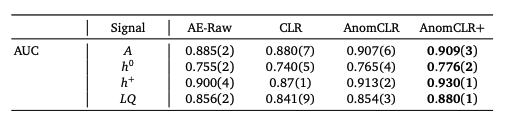

#### Inverse FPR (at TPR = 0.3):

In [ ]:
indxList = indxOfCertainTPR(tprList, TPRval = 0.3)
print(indxList)

[2596, 1126, 96, 1782]


In [ ]:
print('Inverse FPR (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(fprInvList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

Inverse FPR (at TPR = 0.3): 
       $A$: 3.904724716907458 (TPR=0.2999)
     $h^0$: 13.64256480218281 (TPR=0.2999)
   $h^\pm$: 192.30769230769232 (TPR=0.3009)
      $LQ$: 7.541478129713424 (TPR=0.2999)


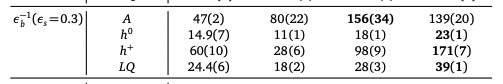

#### SI (at TPR = 0.3):

In [ ]:
print('SI (at TPR = 0.3): ')
for i in range(len(sigTypeNameList)):
  indx = indxList[i]
  strng = '   '+sigTypeNameList[i]+': '+str(SIList[i][indx])+' (TPR='+str(tprList[i][indx])+')'
  print(strng)

SI (at TPR = 0.3): 
       $A$: 0.5924980195752764 (TPR=0.2999)
     $h^0$: 1.1069510990530806 (TPR=0.2999)
   $h^\pm$: 4.133179369216053 (TPR=0.3009)
      $LQ$: 0.8232675628434193 (TPR=0.2999)


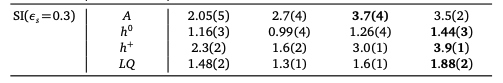

# Ranking of individual OT scores per event

## Sample initial data

We'll start by generating sample sets of different event classes. We'll randomly sample `2*nEvents` background events, and `nEvents` signal events (for each signal type) from the full data arrays. We fix the seeds to ensure reproducibility.

In [ ]:
nEvents   = 100

trimmedDataDict = {}

# Generate 2 different samples of nEvents Background events
random_state                  = Generator(PCG64(123))
trimmedDataDict['bkgEvents1'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

random_state                  = Generator(PCG64(456))
trimmedDataDict['bkgEvents2'] = randomDataSample(dataDict['bkg']['Particles'][:, :, 0:3], nEvents, random_state)

# For each signal type, generate a sample of nEvents Signal events
for alias in sigAliasList:
  random_state                = Generator(PCG64(123))
  trimmedDataDict[alias]      = randomDataSample(dataDict[alias]['Particles'][:, :, 0:3], nEvents, random_state)

In [ ]:
print('trimmedDataDict keys:')
for key in trimmedDataDict.keys():
  print("  ",key)

trimmedDataDict keys:
   bkgEvents1
   bkgEvents2
   sig_A
   sig_h0
   sig_hch
   sig_LQ


## Calculate OT anomaly scores

In [ ]:
scoreDict = calcIndividualOTScores(trimmedDataDict, sigAliasList, speciesList=['MET', 'e', 'mu', 'jet'])

In [ ]:
print('scoreDict keys:')
for key in scoreDict.keys():
  print("  ",key)
  for subkey in scoreDict[key].keys():
    print("    ",subkey)

print("")
print("scoreDict[MET][wBB].shape", scoreDict['MET']['wBB'].shape)

scoreDict keys:
   MET
     wBB
     wBS_sig_A
     wBS_sig_h0
     wBS_sig_hch
     wBS_sig_LQ
   e
     wBB
     wBS_sig_A
     wBS_sig_h0
     wBS_sig_hch
     wBS_sig_LQ
   mu
     wBB
     wBS_sig_A
     wBS_sig_h0
     wBS_sig_hch
     wBS_sig_LQ
   jet
     wBB
     wBS_sig_A
     wBS_sig_h0
     wBS_sig_hch
     wBS_sig_LQ

scoreDict[MET][wBB].shape (10000,)


## Signal Type = 'wBS_sig_A'

In [ ]:
#-- Calculate max individual OT score for each event --#
alias = 'wBS_sig_A'
indxs, maxArr = maxIndividualOTScore(scoreDict, alias)

Signal Type =  wBS_sig_A
Fraction of times that each individual OT score was the maximum for a given event:
   MET: 38.019999999999996 
     e: 14.29 
    mu: 14.91 
   jet: 32.78 


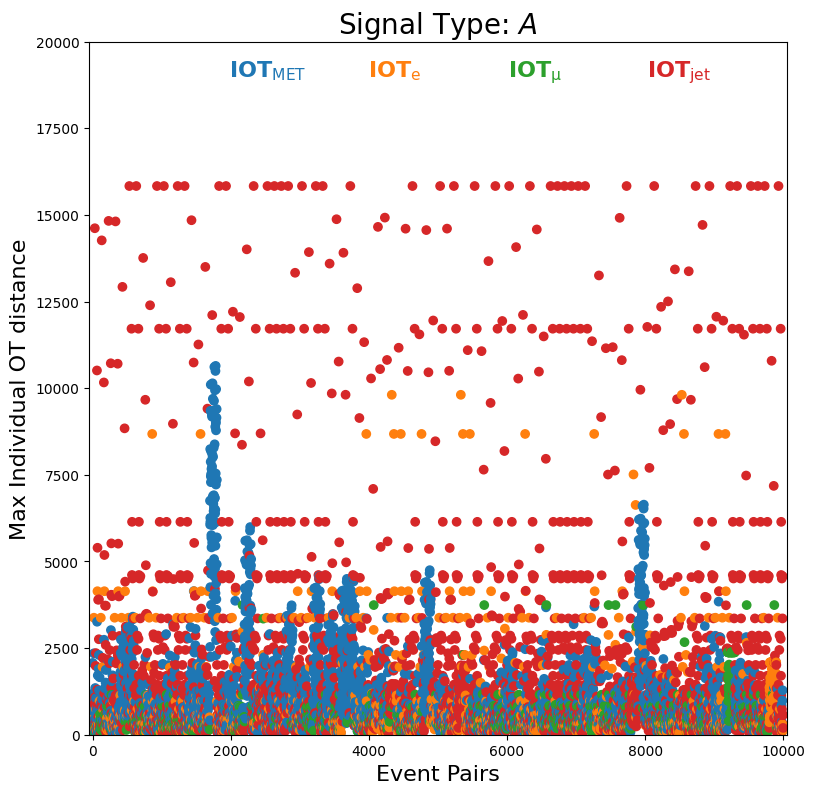

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (-50, 1e4+50)
plotArgDict['xLabel']    = r'Event Pairs'
plotArgDict['yAxisLims'] = (0, 20e3)
plotArgDict['yLabel']    = r'Max Individual OT distance'
plotArgDict['title']     = r'Signal Type: $A$'
plotArgDict['coreColorList'] = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

plotMaxIndividualOTScoresPerEvent(indxs, maxArr, plotArgDict)

## Signal Type = 'wBS_sig_h0'

In [ ]:
#-- Calculate max individual OT score for each event --#
alias = 'wBS_sig_h0'
indxs, maxArr = maxIndividualOTScore(scoreDict, alias)

Signal Type =  wBS_sig_h0
Fraction of times that each individual OT score was the maximum for a given event:
   MET: 53.959999999999994 
     e: 11.32 
    mu: 8.01 
   jet: 26.71 


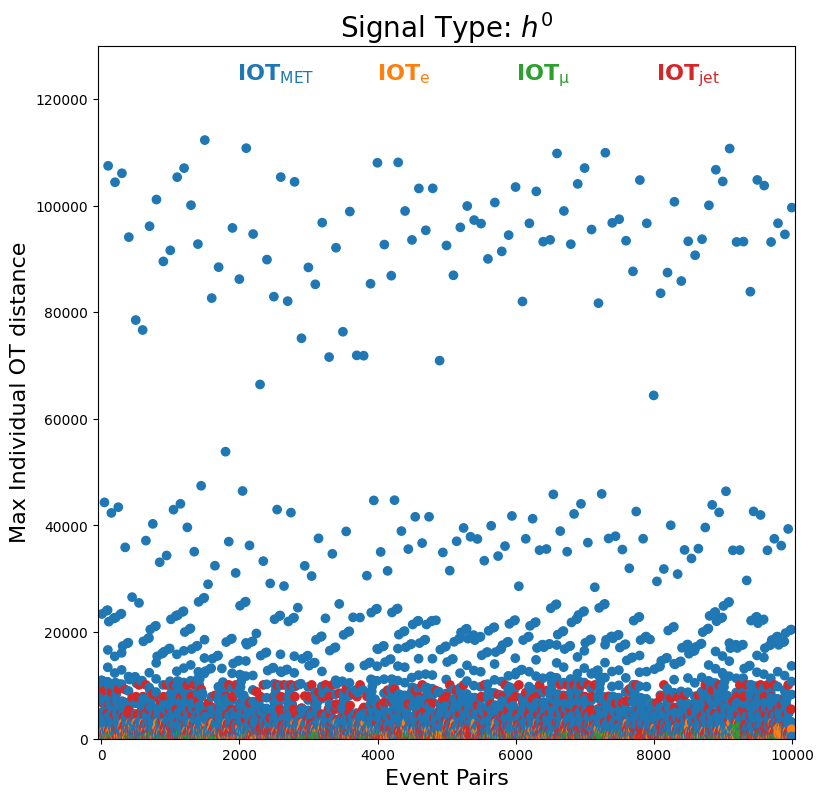

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (-50, 1e4+50)
plotArgDict['xLabel']    = r'Event Pairs'
plotArgDict['yAxisLims'] = (0, 1.3e5)
plotArgDict['yLabel']    = r'Max Individual OT distance'
plotArgDict['title']     = r'Signal Type: $h^0$'
plotArgDict['coreColorList'] = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

plotMaxIndividualOTScoresPerEvent(indxs, maxArr, plotArgDict)

## Signal Type = 'wBS_sig_hch'

In [ ]:
#-- Calculate max individual OT score for each event --#
alias = 'wBS_sig_hch'
indxs, maxArr = maxIndividualOTScore(scoreDict, alias)

Signal Type =  wBS_sig_hch
Fraction of times that each individual OT score was the maximum for a given event:
   MET: 63.85999999999999 
     e: 7.39 
    mu: 5.19 
   jet: 23.56 


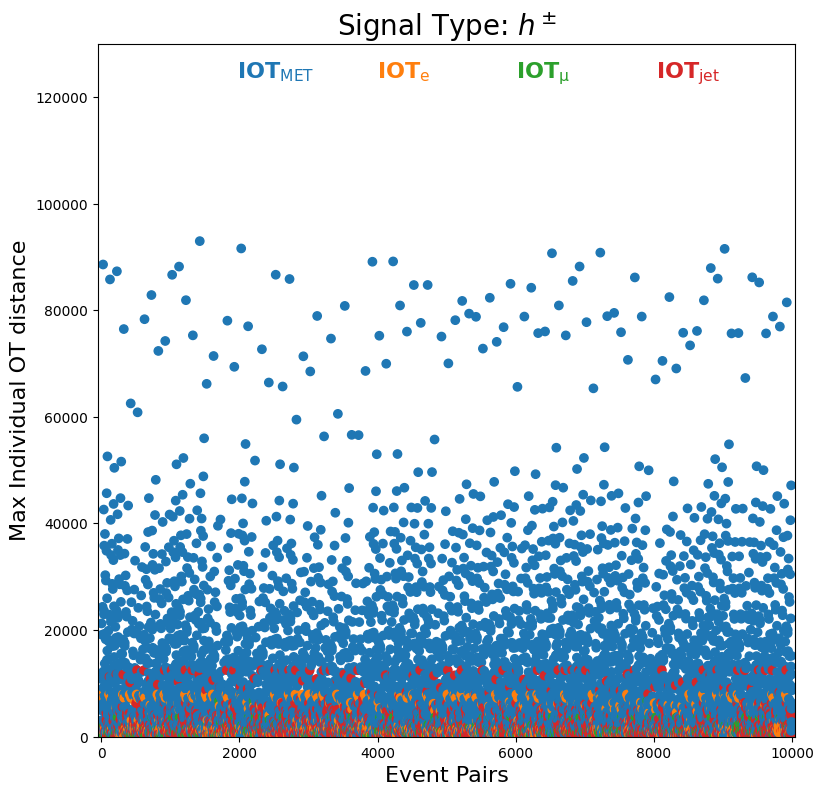

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (-50, 1e4+50)
plotArgDict['xLabel']    = r'Event Pairs'
plotArgDict['yAxisLims'] = (0, 1.3e5)
plotArgDict['yLabel']    = r'Max Individual OT distance'
plotArgDict['title']     = r'Signal Type: $h^\pm$'
plotArgDict['coreColorList'] = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

plotMaxIndividualOTScoresPerEvent(indxs, maxArr, plotArgDict)

## Signal Type = 'wBS_sig_LQ'

In [ ]:
#-- Calculate max individual OT score for each event --#
alias = 'wBS_sig_LQ'
indxs, maxArr = maxIndividualOTScore(scoreDict, alias)

Signal Type =  wBS_sig_LQ
Fraction of times that each individual OT score was the maximum for a given event:
   MET: 42.52 
     e: 9.16 
    mu: 8.709999999999999 
   jet: 39.61 


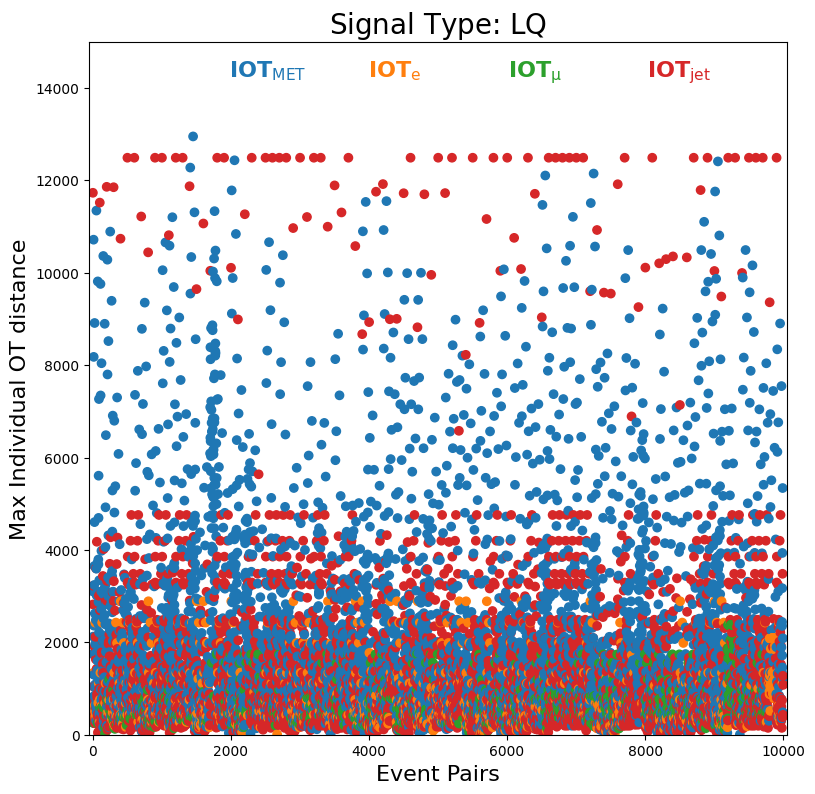

In [ ]:
plotArgDict = {}
plotArgDict['pltDim']    = (3,3)
plotArgDict['xAxisLims'] = (-50, 1e4+50)
plotArgDict['xLabel']    = r'Event Pairs'
plotArgDict['yAxisLims'] = (0, 1.5e4)
plotArgDict['yLabel']    = r'Max Individual OT distance'
plotArgDict['title']     = r'Signal Type: ${\rm LQ}$'
plotArgDict['coreColorList'] = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

plotMaxIndividualOTScoresPerEvent(indxs, maxArr, plotArgDict)